# Machine Learning - MSc 2024/2025

## Task 0 (Know your Data) - Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

from scipy.stats import gaussian_kde, spearmanr, chi2_contingency

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, cross_validate
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay, classification_report
from sklearn.metrics import  precision_recall_curve, roc_auc_score, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score,auc, roc_curve
from sklearn.metrics import f1_score, make_scorer

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn import tree
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn import metrics
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics.cluster import contingency_matrix
from sklearn.decomposition import PCA
import matplotlib.cm as cm

pd.set_option("display.max_columns", None)

seed = 22

## 0.1. Loading Data

In [2]:
breed_labels = pd.read_csv("breed_labels.csv")
color_labels = pd.read_csv("color_labels.csv")
state_labels = pd.read_csv("state_labels.csv")

raw_df = pd.read_csv('PetFinder_dataset.csv', index_col='PetID')
raw_df.drop(columns='Description').head() # hiding Description column for convenience

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,PhotoAmt,AdoptionSpeed
PetID,,,,,,,,,,,,,,,,,,,,,,
86e1089a3,2,Nibble,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,1.0,2
6296e909a,2,No Name Yet,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,2.0,0
3422e4906,1,Brisco,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,7.0,3
5842f1ff5,1,Miko,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,8.0,2
850a43f90,1,Hunter,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,3.0,2


In [3]:
# Checking Raw DF Description alone.
for PetID, Description in raw_df[['Description']].head().iterrows():
    print(f"<{PetID}> {Description.values[0]}")

<86e1089a3> Nibble is a 3+ month old ball of cuteness. He is energetic and playful. I rescued a couple of cats a few months ago but could not get them neutered in time as the clinic was fully scheduled. The result was this little kitty. I do not have enough space and funds to care for more cats in my household. Looking for responsible people to take over Nibble's care.
<6296e909a> I just found it alone yesterday near my apartment. It was shaking so I had to bring it home to provide temporary care.
<3422e4906> Their pregnant mother was dumped by her irresponsible owner at the roadside near some shops in Subang Jaya. Gave birth to them at the roadside. They are all healthy and adorable puppies. Already dewormed, vaccinated and ready to go to a home. No tying or caging for long hours as guard dogs. However, it is acceptable to cage or tie for precautionary purposes. Interested to adopt pls call me.
<5842f1ff5> Good guard dog, very alert, active, obedience waiting for her good master, plz 

## 0.2. Understanding Data

In [4]:
print("Is Index Unique: ", raw_df.index.is_unique)
print(raw_df.info())

Is Index Unique:  True
<class 'pandas.core.frame.DataFrame'>
Index: 14993 entries, 86e1089a3 to a83d95ead
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Type           14993 non-null  int64  
 1   Name           13728 non-null  object 
 2   Age            14993 non-null  int64  
 3   Breed1         14993 non-null  int64  
 4   Breed2         14993 non-null  int64  
 5   Gender         14993 non-null  int64  
 6   Color1         14993 non-null  int64  
 7   Color2         14993 non-null  int64  
 8   Color3         14993 non-null  int64  
 9   MaturitySize   14993 non-null  int64  
 10  FurLength      14993 non-null  int64  
 11  Vaccinated     14993 non-null  int64  
 12  Dewormed       14993 non-null  int64  
 13  Sterilized     14993 non-null  int64  
 14  Health         14993 non-null  int64  
 15  Quantity       14993 non-null  int64  
 16  Fee            14993 non-null  int64  
 17  State          14993

The dataframe consists of 14993 rows and 23 columns. 

The index, "PetID", serves as a unique identifier for each profile.

Only "Name" and "Description" contain null values.

All numeric columns are of integer type, except for "PhotoAmt", which is a float. Non-numeric columns are also present.

#### Creating Plotting Functions

In [5]:
def mybarplot(data, title, xlab, ylab, ax=None):
    counts = data.value_counts().sort_index()
    percentages = (counts / len(data)) * 100

    if ax is None:
        ax = plt.gca()

    bars = sns.barplot(x=counts.index, y=counts.values, color="skyblue", edgecolor="black", ax=ax)

    for bar, percentage in zip(bars.patches, percentages):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.5,
            f'{percentage:.1f}%',
            ha='center',
            va='bottom',
            fontsize=10,
            color='black'
        )

    ax.set_title(title)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

def mycrosstab(var1, var2, title, xlab, ylab, leg, ax=None):
    ct_percentage = pd.crosstab(var1, var2, normalize='index') * 100

    if ax is None:
        ax = plt.gca()

    ct_percentage.plot(kind='bar', stacked=True, ax=ax)

    ax.set_title(title)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.legend(title=leg, bbox_to_anchor=(1.05, 1), loc='upper left')

    return ct_percentage

def plot_side_by_side(data, var1, var2, 
                      barplot_title, barplot_xlab, barplot_ylab, 
                      crosstab_title, crosstab_xlab, crosstab_ylab, crosstab_leg):

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    mybarplot(data, title=barplot_title, xlab=barplot_xlab, ylab=barplot_ylab, ax=axes[0])
    ct_percentage = mycrosstab(var1, var2, title=crosstab_title, xlab=crosstab_xlab, ylab=crosstab_ylab, leg=crosstab_leg, ax=axes[1])
    plt.tight_layout()
    plt.show()
    print('\n', ct_percentage)

def mychi2(var1, var2):
    chi2, pval, dof, _ = chi2_contingency(pd.crosstab(var1, var2))
    print("\nTeste de Independência do Qui-Quadrado:")
    print("Hipótese Nula: As duas variáveis são independentes")
    print("Hipótese Alternativa: As duas variáveis não são independentes")
    print(f"Estatística de Teste: {chi2:.4f}")
    print(f"valor-p: {pval:.4f}")
    print(f"Graus de Liberdade: {dof}")

#### Checking Features Unique Values

We analyzed the top 5 unique values for each column. 

This provides a quick overview of how the data is distributed and reveals some interesting insights, such as:
1. There are more dogs than cats available for adoption.
2. The most common pet names are "Baby" and "Lucky".
3. The rescuer with the highest number of rescues has an ID of 459.
4. The most common primary color among pets is Black, followed by Brown.

In [6]:
# Top 5 most common unique values for each feature.
for column in raw_df.columns:
    print(raw_df[column].value_counts().head(5))

Type
1    8132
2    6861
Name: count, dtype: int64
Name
Baby       66
Lucky      64
No Name    54
Brownie    54
Mimi       52
Name: count, dtype: int64
Age
2     3503
1     2304
3     1966
4     1109
12     967
Name: count, dtype: int64
Breed1
307    5927
266    3634
265    1258
299     342
264     296
Name: count, dtype: int64
Breed2
0      10762
307     1727
266      599
265      321
299      138
Name: count, dtype: int64
Gender
2    7277
1    5536
3    2180
Name: count, dtype: int64
Color1
1    7427
2    3750
3     947
5     884
6     684
Name: count, dtype: int64
Color2
0    4471
7    3438
2    3313
5    1128
6    1063
Name: count, dtype: int64
Color3
0    10604
7     3221
5      417
6      378
4      198
Name: count, dtype: int64
MaturitySize
2    10305
1     3395
3     1260
4       33
Name: count, dtype: int64
FurLength
1    8808
2    5361
3     824
Name: count, dtype: int64
Vaccinated
2    7227
1    5898
3    1868
Name: count, dtype: int64
Dewormed
1    8397
2    4815
3    1781


We also analyzed the number of unique values for each feature.

Since simpler models are generally preferable to more complex ones, we evaluated the unique value counts to identify features that could be simplified or removed before advancing to our predictions.

Notably, features such as "Name", "RescuerID", and "Description" contain a large number of unique values. Given the context of our task—and the fact that these features are non-numerical—the complexity they introduce outweighs their potential contribution. As such, we decided to exclude these features from further analysis.

Additionally, we identified other features, such as "Breed1", "Breed2", "Fee", and "Age", which may benefit from simplification. However, these features are more manageable and relevant to the task, so they will be retained for now.

In [7]:
# Checking for the ammount of unique values for each feature.
for column in raw_df.columns:
    print(f"{column}: {len(raw_df[column].unique())} Unique Values")

Type: 2 Unique Values
Name: 9060 Unique Values
Age: 106 Unique Values
Breed1: 176 Unique Values
Breed2: 135 Unique Values
Gender: 3 Unique Values
Color1: 7 Unique Values
Color2: 7 Unique Values
Color3: 6 Unique Values
MaturitySize: 4 Unique Values
FurLength: 3 Unique Values
Vaccinated: 3 Unique Values
Dewormed: 3 Unique Values
Sterilized: 3 Unique Values
Health: 3 Unique Values
Quantity: 19 Unique Values
Fee: 74 Unique Values
State: 14 Unique Values
RescuerID: 5595 Unique Values
VideoAmt: 9 Unique Values
Description: 14032 Unique Values
PhotoAmt: 31 Unique Values
AdoptionSpeed: 5 Unique Values


#### Checking Target Feature - Adoption Speed

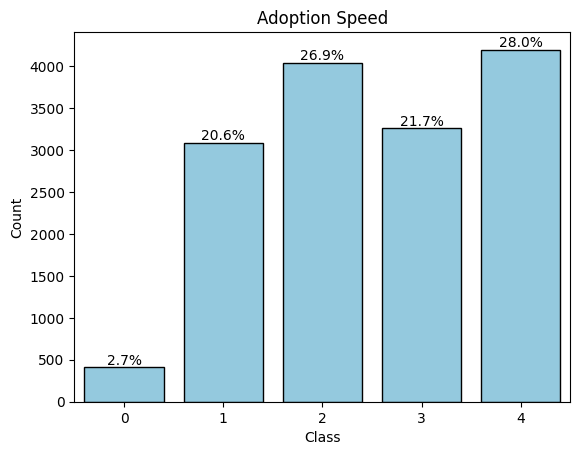

In [8]:
mybarplot(data = raw_df['AdoptionSpeed'], title = "Adoption Speed", xlab = "Class", ylab = "Count", ax=None)

- Class 0 - Adopted within the first day: 2.7%
- Class 1 - Adopted within the first week: 20.6%
- Class 2 - Adopted within the first month: 26.9%
- Class 3 - Adopted within the 2nd/3rd month: 21.7%
- Class 4 - Not adopted after 100+ days: 28.0%

This feature exhibits some class imbalance, as the class 0 (Adopted within the first day) accounts for less than 3% of all profiles, while the other classes each make up at least 20%.

Additionally, we observe that 72% of profiles correspond to pets adopted within the first 3 months, while the remaining 28% represent pets that were not adopted after being listed for over 100 days.

#### Checking Other Features Distributions By Adoption Speed

##### Type

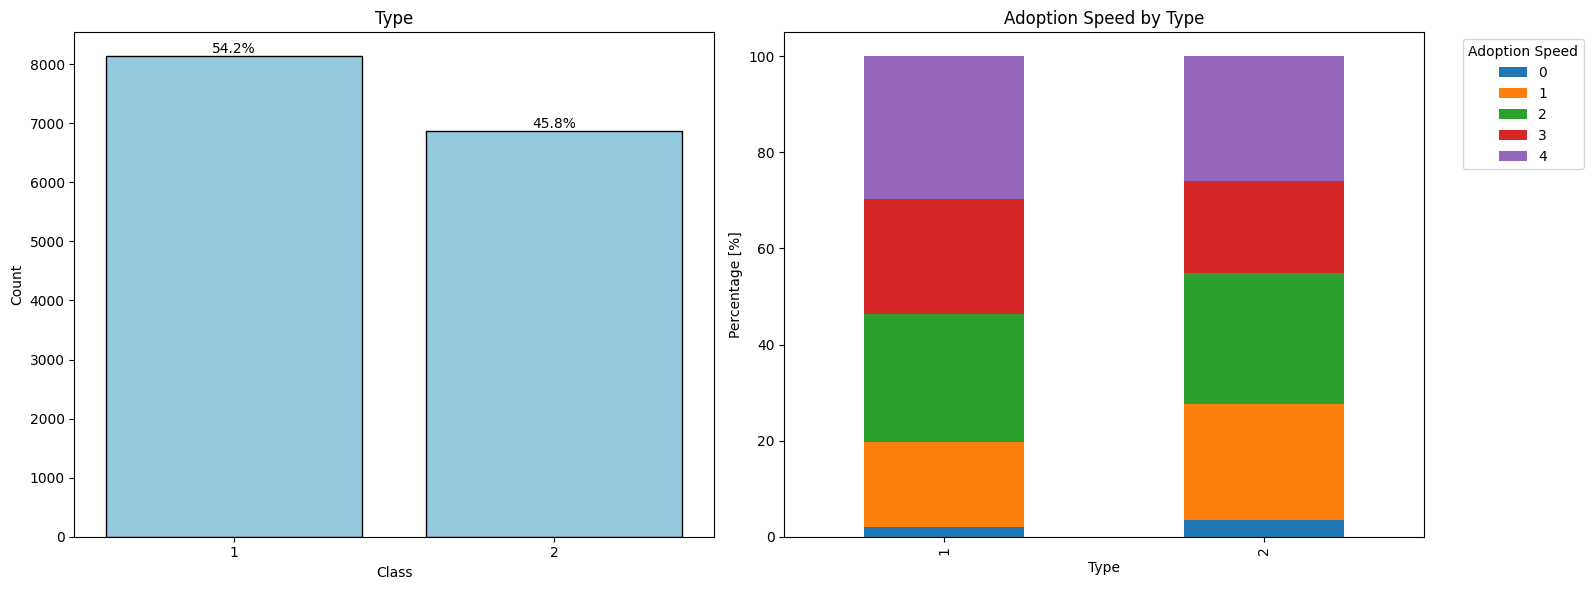


 AdoptionSpeed         0          1          2          3          4
Type                                                               
1              2.090507  17.646335  26.610920  23.967044  29.685194
2              3.498032  24.121848  27.299228  19.093427  25.987465

Teste de Independência do Qui-Quadrado:
Hipótese Nula: As duas variáveis são independentes
Hipótese Alternativa: As duas variáveis não são independentes
Estatística de Teste: 162.1682
valor-p: 0.0000
Graus de Liberdade: 4


In [9]:
plot_side_by_side(
    data=raw_df['Type'],
    var1=raw_df['Type'],
    var2=raw_df['AdoptionSpeed'],
    barplot_title="Type",
    barplot_xlab="Class",
    barplot_ylab="Count",
    crosstab_title="Adoption Speed by Type",
    crosstab_xlab="Type",
    crosstab_ylab="Percentage [%]",
    crosstab_leg="Adoption Speed"
)

mychi2(var1 = raw_df["Type"], var2 = raw_df["AdoptionSpeed"])

Approximately 54.2% of the profiles correspond to dogs, while 45.8% correspond to cats, indicating a good balance between dog and cat profiles.

It is observed that cat profiles have a higher likelihood of being adopted and tend to be adopted more quickly.

At any conventional level of significance, we reject the null hypothesis that the two variables are independent. There is statistical evidence to suggest that the two variables are associated.

##### Age

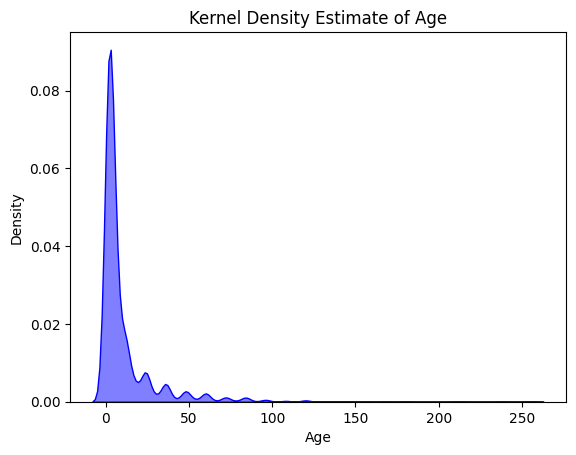


Coeficiente de Spearman: 0.2095, valor-p: 0.0000


In [10]:
sns.kdeplot(raw_df["Age"], fill=True, color='blue', alpha=0.5)
plt.title("Kernel Density Estimate of Age")
plt.xlabel("Age")
plt.ylabel("Density")
plt.show()

corr, pval = spearmanr(raw_df["Age"], raw_df["AdoptionSpeed"])
print(f"\nCoeficiente de Spearman: {corr:.4f}, valor-p: {pval:.4f}")

Age is positively correlated with adoption speed, meaning that the older the pet, the higher the adoption speed class it tends to belong to.

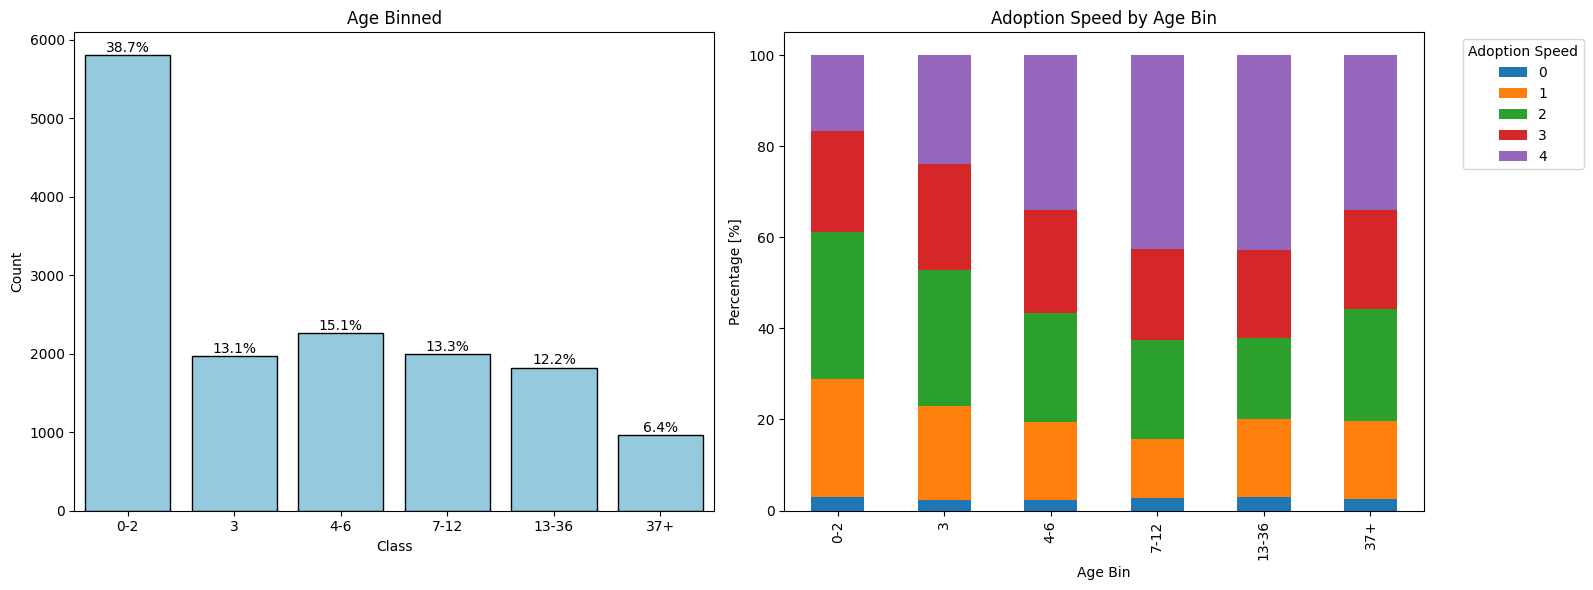


 AdoptionSpeed         0          1          2          3          4
AgeBinned                                                          
0-2            2.910281  25.968659  32.271397  22.283451  16.566213
3              2.238047  20.752798  29.806714  23.296033  23.906409
4-6            2.254642  17.285588  23.828470  22.546419  34.084881
7-12           2.804206  12.919379  21.632449  20.030045  42.613921
13-36          3.070175  17.050439  17.817982  19.243421  42.817982
37+            2.505219  17.118998  24.739040  21.607516  34.029228


In [11]:
bins = [0, 2, 3, 6, 12, 36, float('inf')]
labels = ['0-2', '3', '4-6', '7-12', '13-36', '37+']
raw_df['AgeBinned'] = pd.cut(raw_df['Age'], bins=bins, labels=labels, right=True)

plot_side_by_side(
    data=raw_df['AgeBinned'],
    var1=raw_df['AgeBinned'],
    var2=raw_df['AdoptionSpeed'],
    barplot_title="Age Binned",
    barplot_xlab="Class",
    barplot_ylab="Count",
    crosstab_title="Adoption Speed by Age Bin",
    crosstab_xlab="Age Bin",
    crosstab_ylab="Percentage [%]",
    crosstab_leg="Adoption Speed"
)

- Age = 0 likely indicates that the pet is less than 1 month old.
- The oldest pet listed is 21 years old, which, while possible, is extremely rare.
- Approximately 81% of the pets are one year old or younger.
- The age distribution shows positive skewness.
- Adoption probability and speed tend to decrease as pets get older. Interestingly, profiles of pets aged 37 months or older show a slight increase in adoption probability. However, this is likely influenced by the smaller sample size in this age group.

##### Breed

The breed information is divided between two features: Breed1 and Breed2.

In [12]:
breed_labels[breed_labels["BreedName"] == "Mixed Breed"] 

,BreedID,Type,BreedName
240,307,1,Mixed Breed


BreedID 307 identifies dogs that are not purebred.

In [13]:
breed_labels[breed_labels["BreedID"].isin([264, 265, 266, 299])]

,BreedID,Type,BreedName
264,264,2,Domestic Long Hair
265,265,2,Domestic Medium Hair
266,266,2,Domestic Short Hair
299,299,2,Tabby


"The domestic short-haired and domestic long-haired cat types are not breeds, but terms used (with various spellings) in the cat fancy to describe "mongrel" or "bicolor" cats by coat length, ones that do not belong to a particular breed. Some registries such as the Cat Fanciers' Association allow for domestic short hairs and domestic long hairs to be registered for the purpose of outcrossing.[7] They should not be confused with standardized breeds with similar names, such as the British Shorthair and Oriental Longhair."
Source: https://en.wikipedia.org/wiki/List_of_cat_breeds

"Tabby" is not a breed of cat but a coat pattern found in many cat breeds. It is very common amongst non-pedigree cats around the world. Source: https://en.wikipedia.org/wiki/Tabby_cat

BreedID's 264, 265, 266 and 299 identify cats that are not purebred.

In [14]:
print("Count of Breed1 = 0: ", raw_df[raw_df["Breed1"] == 0].shape[0])
print("Count of Breed2 = 0: ", raw_df[raw_df["Breed2"] == 0].shape[0])
print("Count of Breed1 = 0 and Breed2 = 0: ", raw_df[(raw_df["Breed1"] == 0) & (raw_df["Breed2"] == 0)].shape[0])

Count of Breed1 = 0:  5
Count of Breed2 = 0:  10762
Count of Breed1 = 0 and Breed2 = 0:  0


- The value of zero is not associated with any breed.
- There are 5 profiles where the first breed is not identified, but the second breed is.
- There are 10,762 profiles where the second breed is not identified, but the first breed is.
- There are no profiles where neither "Breed1" nor "Breed2" is identified.

In [15]:
raw_df["PureBreed"] = 0 # Mixed Breed

For a dog to be considered purebred, it must have only one breed identified and no indication of being a mixed breed.

In [16]:
mask1 = (raw_df["Type"] == 1) & ( (raw_df["Breed1"] == 0) & (raw_df["Breed2"] !=307) )
mask2 = (raw_df["Type"] == 1) & ( (raw_df["Breed1"] != 307) & (raw_df["Breed2"] == 0) )
raw_df.loc[mask1 | mask2, "PureBreed"] = 1
raw_df[mask1 | mask2].shape[0]

1098

There are only 1098 profiles of purebred dogs.

For a cat to be considered purebred, it must have only one breed identified and no indication of being Domestic or Tabby.

In [17]:
mask1 = (raw_df["Type"] == 2) & ( (raw_df["Breed1"] == 0) & (~raw_df["Breed2"].isin([264, 265, 266, 299])) )
mask2 = (raw_df["Type"] == 2) & ( (~raw_df["Breed1"].isin([264, 265, 266, 299])) & (raw_df["Breed2"] == 0) )
raw_df.loc[mask1 | mask2, "PureBreed"] = 1
raw_df[mask1 | mask2].shape[0]

668

There are only 668 profiles of purebred cats.

In [18]:
print(set(raw_df.loc[raw_df["Type"] == 1, "Breed1"].unique()) - set(breed_labels.loc[breed_labels["Type"] == 1, "BreedID"].unique()))
print(set(raw_df.loc[raw_df["Type"] == 1, "Breed2"].unique()) - set(breed_labels.loc[breed_labels["Type"] == 1, "BreedID"].unique()))

{0}
{0}


There are no cat breeds associated with dog profiles.

In [19]:
print(set(raw_df.loc[raw_df["Type"] == 2, "Breed1"].unique()) - set(breed_labels.loc[breed_labels["Type"] == 2, "BreedID"].unique()))
print(set(raw_df.loc[raw_df["Type"] == 2, "Breed2"].unique()) - set(breed_labels.loc[breed_labels["Type"] == 2, "BreedID"].unique()))

{0, 70, 205, 15, 114, 307, 21, 25, 218}
{0, 218, 21, 5}


There are dog breeds associated with some cat profiles. In these cases, the cats will be considered mixed breed.

In [20]:
mask1 = (raw_df["Type"] == 2) & (raw_df["Breed1"].isin([15, 21, 25, 70, 114, 205, 218, 307]))
mask2 = (raw_df["Type"] == 2) & (raw_df["Breed2"].isin([5, 21, 218]))
raw_df.loc[mask1 | mask2, "PureBreed"] = 0

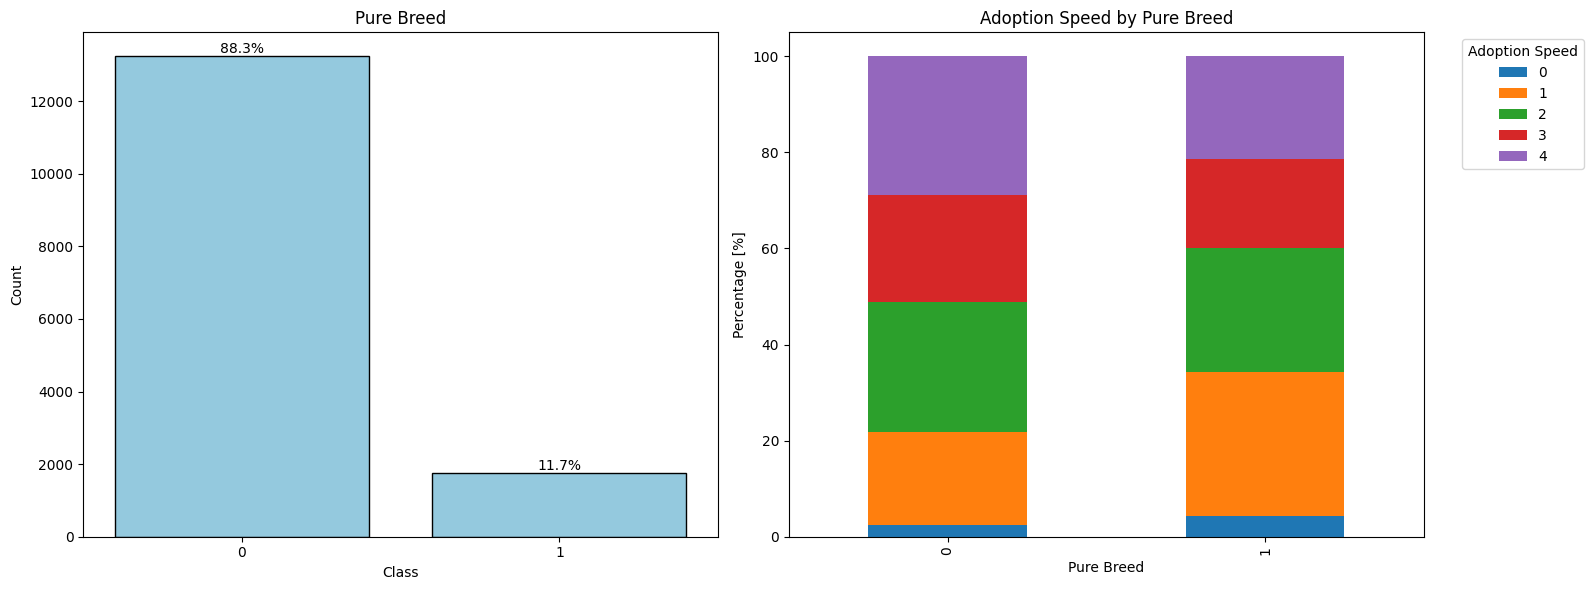


 AdoptionSpeed         0          1          2          3          4
PureBreed                                                          
0              2.515866  19.363856  27.085222  22.151707  28.883348
1              4.382470  29.994308  25.725669  18.611269  21.286283

Teste de Independência do Qui-Quadrado:
Hipótese Nula: As duas variáveis são independentes
Hipótese Alternativa: As duas variáveis não são independentes
Estatística de Teste: 146.8022
valor-p: 0.0000
Graus de Liberdade: 4


In [21]:
plot_side_by_side(
    data=raw_df['PureBreed'],
    var1=raw_df['PureBreed'],
    var2=raw_df['AdoptionSpeed'],
    barplot_title="Pure Breed",
    barplot_xlab="Class",
    barplot_ylab="Count",
    crosstab_title="Adoption Speed by Pure Breed",
    crosstab_xlab="Pure Breed",
    crosstab_ylab="Percentage [%]",
    crosstab_leg="Adoption Speed"
)

mychi2(var1 = raw_df["PureBreed"], var2 = raw_df["AdoptionSpeed"])

- Only 11.7% of the profiles correspond to purebred animals.
- It is clear that purebred animals are more likely to be adopted and tend to be adopted more quickly.
- At any conventional level of significance, we reject the null hypothesis that the two variables are independent. There is statistical evidence to suggest that the two variables are associated.

##### Gender

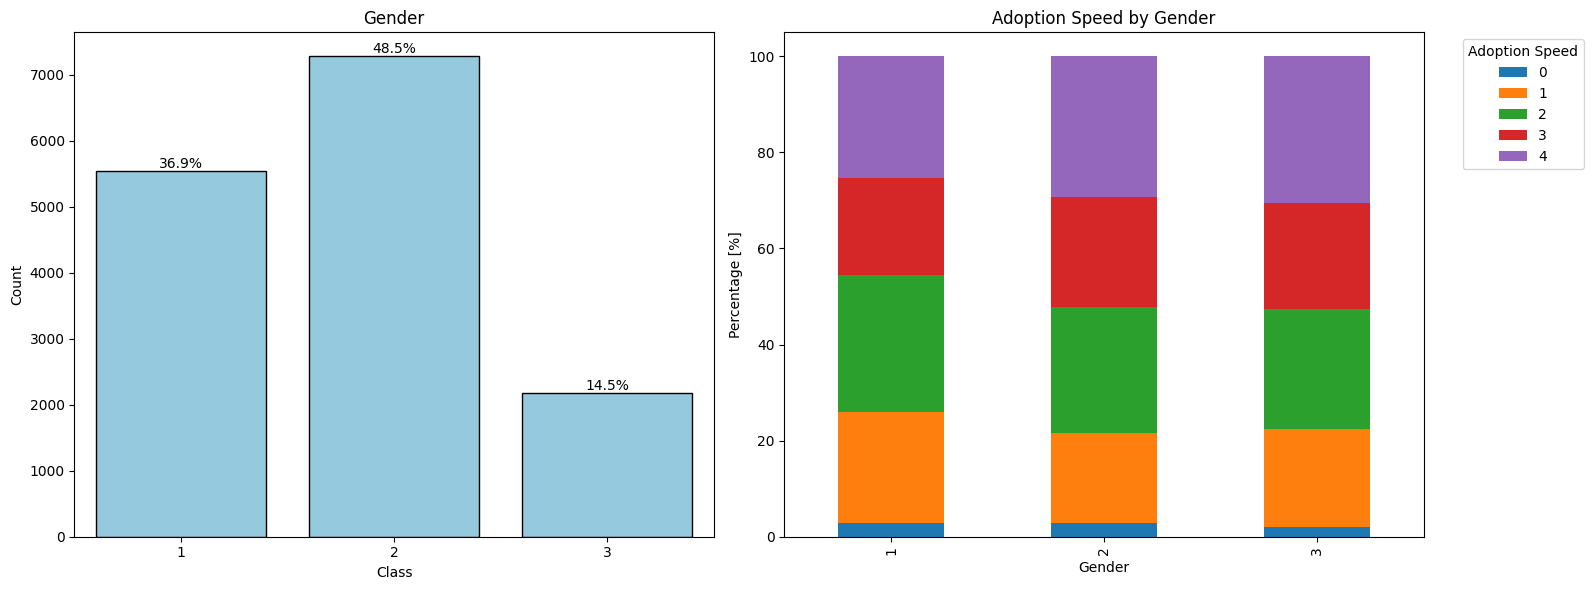


 AdoptionSpeed         0          1          2          3          4
Gender                                                             
1              2.890173  23.175578  28.504335  20.032514  25.397399
2              2.803353  18.771472  26.260822  22.962759  29.201594
3              2.110092  20.229358  25.137615  21.972477  30.550459

Teste de Independência do Qui-Quadrado:
Hipótese Nula: As duas variáveis são independentes
Hipótese Alternativa: As duas variáveis não são independentes
Estatística de Teste: 77.1000
valor-p: 0.0000
Graus de Liberdade: 8


In [22]:
plot_side_by_side(
    data=raw_df['Gender'],
    var1=raw_df['Gender'],
    var2=raw_df['AdoptionSpeed'],
    barplot_title="Gender",
    barplot_xlab="Class",
    barplot_ylab="Count",
    crosstab_title="Adoption Speed by Gender",
    crosstab_xlab="Gender",
    crosstab_ylab="Percentage [%]",
    crosstab_leg="Adoption Speed"
)

mychi2(var1 = raw_df["Gender"], var2 = raw_df["AdoptionSpeed"])

- Female pets account for 48.5% of the profiles, male pets for 36.9%, and the remaining 14.5% are mixed profiles.

- Male profiles have a higher likelihood of being adopted and tend to be adopted more quickly. There is no significant distinction between female profiles and mixed profiles.

- At any conventional level of significance, we reject the null hypothesis that the two variables are independent. There is statistical evidence to suggest that the two variables are associated.

##### Vaccinated

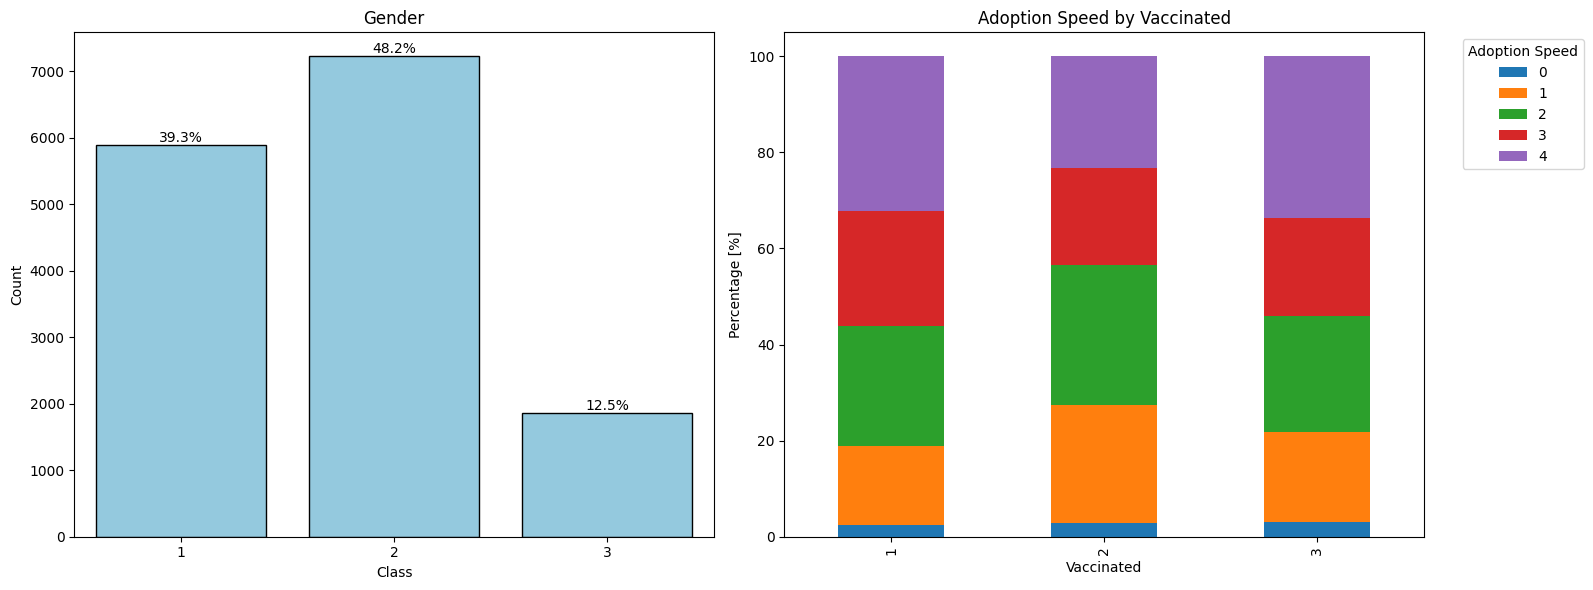


 AdoptionSpeed         0          1          2          3          4
Vaccinated                                                         
1              2.475415  16.361478  24.974568  24.059003  32.129535
2              2.850422  24.588349  29.223744  20.188183  23.149301
3              3.104925  18.629550  24.197002  20.396146  33.672377

Teste de Independência do Qui-Quadrado:
Hipótese Nula: As duas variáveis são independentes
Hipótese Alternativa: As duas variáveis não são independentes
Estatística de Teste: 283.4259
valor-p: 0.0000
Graus de Liberdade: 8


In [23]:
plot_side_by_side(
    data=raw_df['Vaccinated'],
    var1=raw_df['Vaccinated'],
    var2=raw_df['AdoptionSpeed'],
    barplot_title="Gender",
    barplot_xlab="Class",
    barplot_ylab="Count",
    crosstab_title="Adoption Speed by Vaccinated",
    crosstab_xlab="Vaccinated",
    crosstab_ylab="Percentage [%]",
    crosstab_leg="Adoption Speed"
)

mychi2(var1 = raw_df["Vaccinated"], var2 = raw_df["AdoptionSpeed"])

- Approximately 48.2% of the profiles correspond to animals that are not vaccinated, while 39.3% correspond to vaccinated animals. In 12.5% of cases, vaccination status is unknown.
- Profiles of non-vaccinated animals have a higher likelihood of being adopted and tend to be adopted more quickly. This may be because people often prefer adopting younger animals, which may not yet be old enough to be fully vaccinated.
- Interestingly, profiles with unknown vaccination status are more likely to be adopted on the same day they were listed.
- At any conventional level of significance, we reject the null hypothesis that the two variables are independent. There is statistical evidence suggesting that the two variables are associated.

##### Dewormed

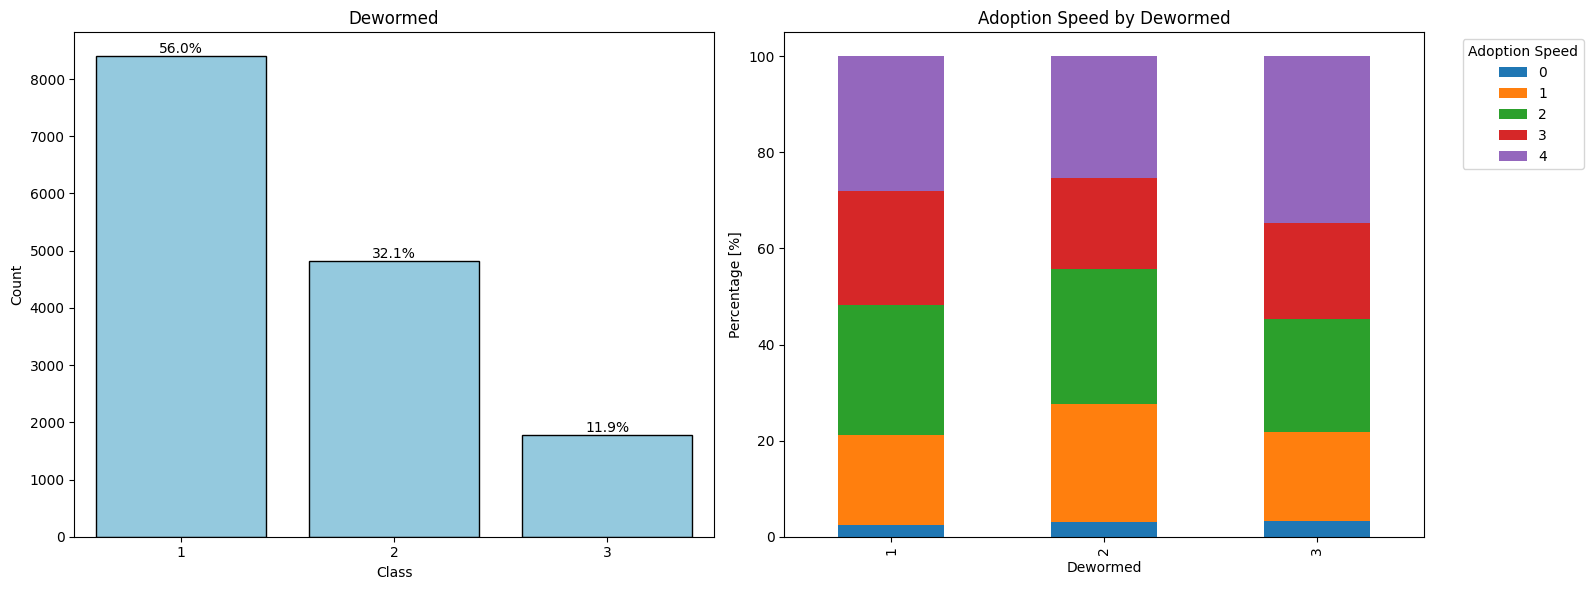


 AdoptionSpeed         0          1          2          3          4
Dewormed                                                           
1              2.441348  18.720972  27.069191  23.675122  28.093367
2              3.032191  24.672897  27.975078  18.982347  25.337487
3              3.312746  18.528916  23.413812  20.044919  34.699607

Teste de Independência do Qui-Quadrado:
Hipótese Nula: As duas variáveis são independentes
Hipótese Alternativa: As duas variáveis não são independentes
Estatística de Teste: 147.8568
valor-p: 0.0000
Graus de Liberdade: 8


In [24]:
plot_side_by_side(
    data=raw_df['Dewormed'],
    var1=raw_df['Dewormed'],
    var2=raw_df['AdoptionSpeed'],
    barplot_title="Dewormed",
    barplot_xlab="Class",
    barplot_ylab="Count",
    crosstab_title="Adoption Speed by Dewormed",
    crosstab_xlab="Dewormed",
    crosstab_ylab="Percentage [%]",
    crosstab_leg="Adoption Speed"
)

mychi2(var1 = raw_df["Dewormed"], var2 = raw_df["AdoptionSpeed"])

- Approximately 56.0% of the profiles correspond to dewormed animals, 32.1% to animals not dewormed, and 11.9% to profiles where the deworming status is unknown.
- There are more profiles of dewormed animals than vaccinated ones.
- Profiles of animals that are not dewormed have a higher likelihood of being adopted and tend to be adopted more quickly.
- Interestingly, profiles with unknown dewormed status are more likely to be adopted on the same day they were listed.
- At any conventional level of significance, we reject the null hypothesis that the two variables are independent. There is statistical evidence suggesting that the two variables are associated.

##### Sterilized

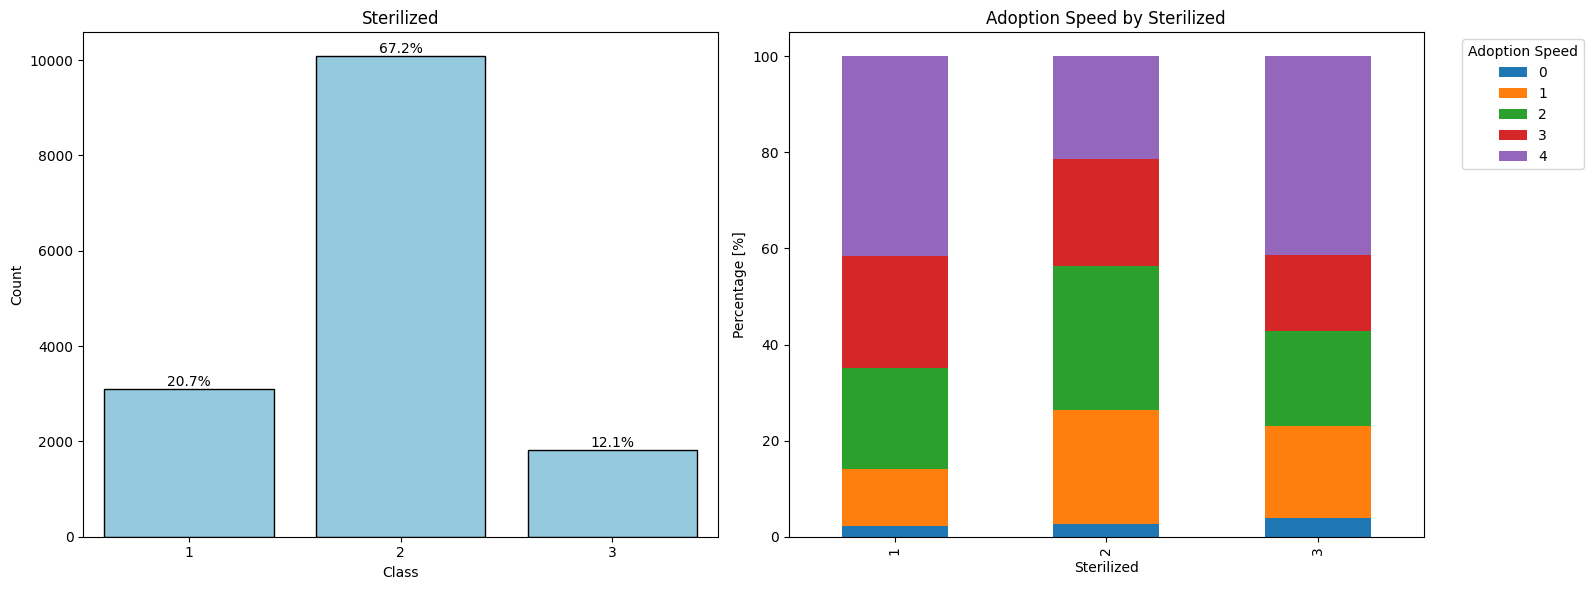


 AdoptionSpeed         0          1          2          3          4
Sterilized                                                         
1              2.257336  11.738149  21.154466  23.218317  41.631732
2              2.679369  23.598293  29.989084  22.337997  21.395257
3              3.856749  19.173554  19.779614  15.867769  41.322314

Teste de Independência do Qui-Quadrado:
Hipótese Nula: As duas variáveis são independentes
Hipótese Alternativa: As duas variáveis não são independentes
Estatística de Teste: 794.3939
valor-p: 0.0000
Graus de Liberdade: 8


In [25]:
plot_side_by_side(
    data=raw_df['Sterilized'],
    var1=raw_df['Sterilized'],
    var2=raw_df['AdoptionSpeed'],
    barplot_title="Sterilized",
    barplot_xlab="Class",
    barplot_ylab="Count",
    crosstab_title="Adoption Speed by Sterilized",
    crosstab_xlab="Sterilized",
    crosstab_ylab="Percentage [%]",
    crosstab_leg="Adoption Speed"
)

mychi2(var1 = raw_df["Sterilized"], var2 = raw_df["AdoptionSpeed"])

- Approximately 67.2% of the profiles correspond to animals that are not spayed or neutered, which is not surprising given that 81.4% of the profiles are for animals aged 1 year or younger, and spaying or neutering can only be performed after reaching a certain age (usually close to 1 year). 20.7% of the profiles correspond to spayed or neutered animals, and 12.1% are for animals whose spaying or neutering status is unknown.
- Profiles of animals that are not spayed or neutered have a higher likelihood of being adopted and tend to be adopted more quickly.
- Interestingly, profiles with unknown spaying or neutering status are more likely to be adopted on the same day they were listed. Additionally, their adoption probability is roughly the same as that of spayed or neutered animals.
- At any conventional level of significance, we reject the null hypothesis that the two variables are independent. There is statistical evidence suggesting that the two variables are associated.

##### State

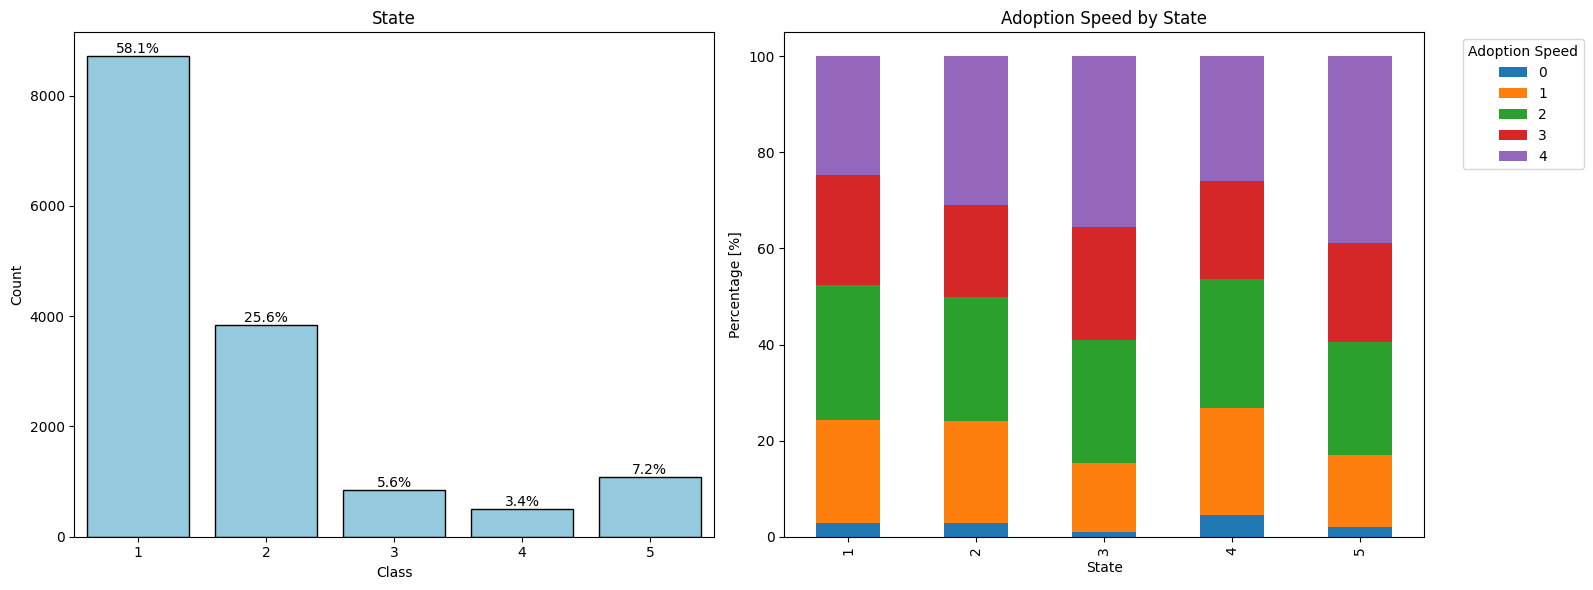


 AdoptionSpeed         0          1          2          3          4
TopState                                                           
1              2.823043  21.540050  27.943539  22.997475  24.695892
2              2.912874  21.170351  25.903771  19.011704  31.001300
3              0.948992  14.472123  25.622776  23.368921  35.587189
4              4.536489  22.287968  26.824458  20.315582  26.035503
5              1.937269  15.129151  23.431734  20.664207  38.837638

Teste de Independência do Qui-Quadrado:
Hipótese Nula: As duas variáveis são independentes
Hipótese Alternativa: As duas variáveis não são independentes
Estatística de Teste: 196.9615
valor-p: 0.0000
Graus de Liberdade: 16


In [26]:
raw_df["TopState"] = 5

mask = raw_df["State"] == 41326
raw_df.loc[mask, "TopState"] = 1

mask = raw_df["State"] == 41401
raw_df.loc[mask, "TopState"] = 2

mask = raw_df["State"] == 41327
raw_df.loc[mask, "TopState"] = 3

mask = raw_df["State"] == 41336
raw_df.loc[mask, "TopState"] = 4


plot_side_by_side(
    data=raw_df['TopState'],
    var1=raw_df['TopState'],
    var2=raw_df['AdoptionSpeed'],
    barplot_title="State",
    barplot_xlab="Class",
    barplot_ylab="Count",
    crosstab_title="Adoption Speed by State",
    crosstab_xlab="State",
    crosstab_ylab="Percentage [%]",
    crosstab_leg="Adoption Speed"
)

mychi2(var1 = raw_df["TopState"], var2 = raw_df["AdoptionSpeed"])

- Approximately 58.1% of the profiles are associated with the state of Selangor, 25.6% with Kuala Lumpur, 5.6% with Pulau Pinang, 3.4% with Johor, and 7.2% with other states.
- Profiles associated with Selangor have a higher likelihood of being adopted, while profiles from Johor are more likely to be adopted more quickly (however, this is likely influenced by the smaller sample size in the Johor group).
- At any conventional level of significance, we reject the null hypothesis that the two variables are independent. There is statistical evidence suggesting that the two variables are associated.

##### Color

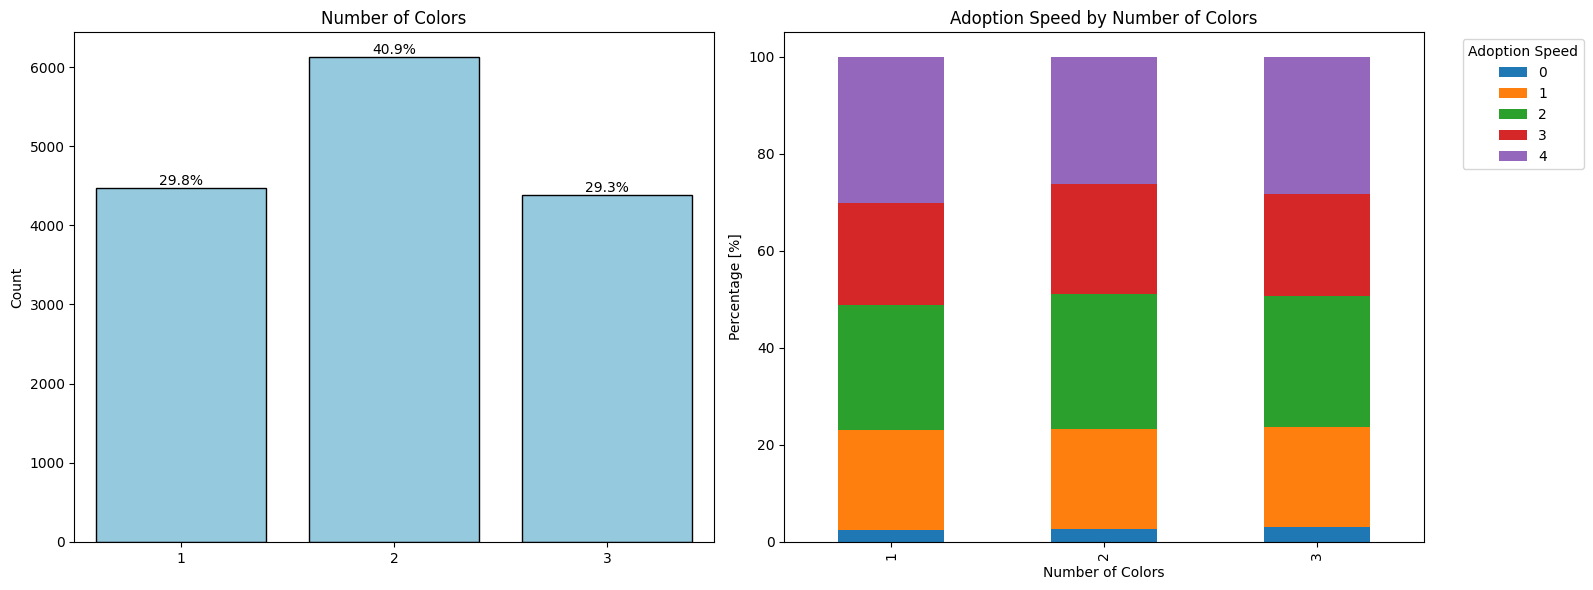


 AdoptionSpeed         0          1          2          3          4
ColorsCount                                                        
1              2.505032  20.577052  25.766048  21.046746  30.105122
2              2.641448  20.691342  27.653677  22.762107  26.251427
3              3.098656  20.528594  27.090453  21.007063  28.275234


In [27]:
def count_unique_colors(row):
    colors = {row["Color1"], row["Color2"], row["Color3"]} 
    colors.discard(0)
    return len(colors)
    
raw_df["ColorsCount"] = raw_df[["Color1", "Color2", "Color3"]].apply(count_unique_colors, axis=1)


plot_side_by_side(
    data=raw_df['ColorsCount'],
    var1=raw_df['ColorsCount'],
    var2=raw_df['AdoptionSpeed'],
    barplot_title="Number of Colors",
    barplot_xlab="",
    barplot_ylab="Count",
    crosstab_title="Adoption Speed by Number of Colors",
    crosstab_xlab="Number of Colors",
    crosstab_ylab="Percentage [%]",
    crosstab_leg="Adoption Speed"
)

- Approximately 40.9% of the profiles correspond to animals with two colors, with a similar number of profiles for animals with one color and those with three colors.
- The number of colors does not appear to significantly impact adoption speed. Animals with a single color have a lower likelihood of being adopted, as well as a slower adoption rate.

##### Fee

In [28]:
print(raw_df["Fee"].describe())
print('\n', format(raw_df[raw_df["Fee"] == 0].shape[0]/raw_df.shape[0], ".1%"))

count    14993.000000
mean        21.259988
std         78.414548
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       3000.000000
Name: Fee, dtype: float64

 84.5%


- The Fee variable exhibits positive skewness.
- 84.5% of the profiles have a Fee value of zero, indicating free adoptions.
- Notably, there appear to be outliers, as the maximum Fee is 3000.

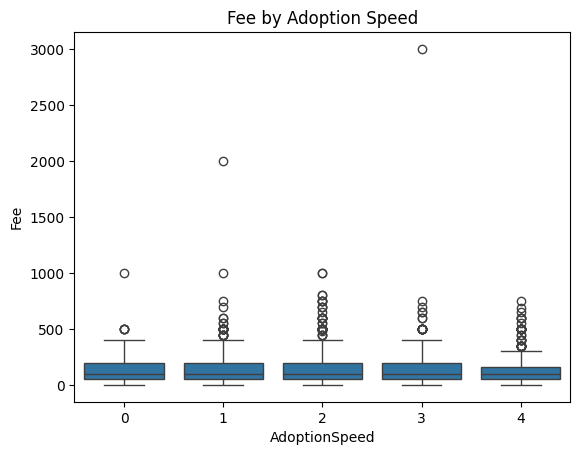


                count        mean         std  min   25%    50%    75%     max
AdoptionSpeed                                                                
0               53.0  170.849057  184.041320  1.0  50.0  100.0  200.0  1000.0
1              479.0  140.774530  163.265164  1.0  50.0  100.0  200.0  2000.0
2              607.0  143.540362  156.574884  1.0  50.0  100.0  200.0  1000.0
3              470.0  139.731915  185.491189  1.0  50.0  100.0  200.0  3000.0
4              721.0  124.080444  115.714419  1.0  50.0  100.0  160.0   750.0

 Coeficiente de Spearman: 0.0185, valor-p: 0.0237


In [29]:
sns.boxplot(x='AdoptionSpeed', y='Fee', data=raw_df[raw_df["Fee"] !=0])
plt.xlabel("AdoptionSpeed")
plt.ylabel("Fee")
plt.title('Fee by Adoption Speed')
plt.show()

print('\n', raw_df[raw_df["Fee"] !=0].groupby('AdoptionSpeed')['Fee'].describe())

corr, pval = spearmanr(raw_df["Fee"], raw_df["AdoptionSpeed"])
print('\n', f"Coeficiente de Spearman: {corr:.4f}, valor-p: {pval:.4f}")

- Considering only the profiles where the Fee is non-zero, does not appear to exist a significant difference in the distribution of Fee across different adoption speed classes.
- It's worth noting that most fees are less than or equal to 100, with only 6 profiles having a fee of 1000 or higher.
- The Spearman correlation coefficient is positive, and given the p-value, it is statistically significant at significance levels above 2.37%, indicating a positive correlation between the variables. However, given the coefficient's proximity to zero, the correlation is very weak.

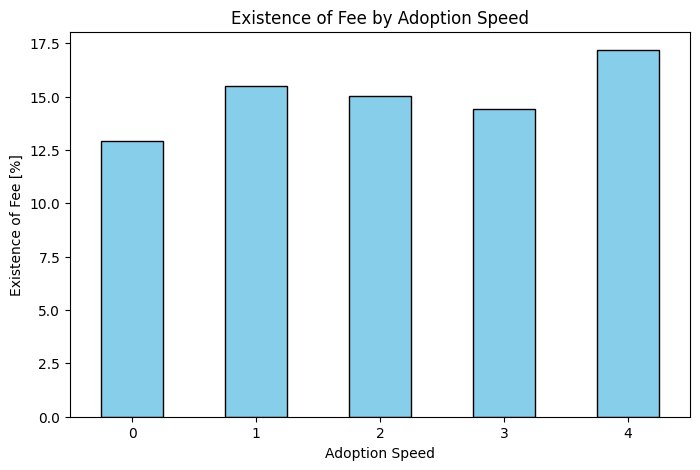


Teste de Independência do Qui-Quadrado:
Hipótese Nula: As duas variáveis são independentes
Hipótese Alternativa: As duas variáveis não são independentes
Estatística de Teste: 14.6129
valor-p: 0.0056
Graus de Liberdade: 4


In [30]:
# A new variable is created, which takes the value 1 if the Fee is non-zero, and 0 if the Fee is zero.
raw_df["PayFee"] = (raw_df["Fee"] != 0).astype(int)

mean_payfee = raw_df.groupby("AdoptionSpeed")["PayFee"].agg("mean")*100
plt.figure(figsize=(8, 5))
mean_payfee.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Existence of Fee by Adoption Speed")
plt.xlabel("Adoption Speed")
plt.ylabel("Existence of Fee [%]")
plt.xticks(rotation=0)
plt.show()

mychi2(var1 = raw_df["PayFee"], var2 = raw_df["AdoptionSpeed"])

- Approximately 12.9% of the profiles adopted on the same day as the listing had an associated fee. Additionally, 17.2% of the profiles that were not adopted had a fee. This suggests that the presence of a fee reduces the likelihood of adoption. However, for AdoptionSpeed classes 1, 2, and 3, the influence of the fee is less evident.
- At a significance level higher than the p-value (e.g., 5%), we reject the null hypothesis that the two variables are independent. There is statistical evidence indicating that the two variables are associated.

##### Maturity Size

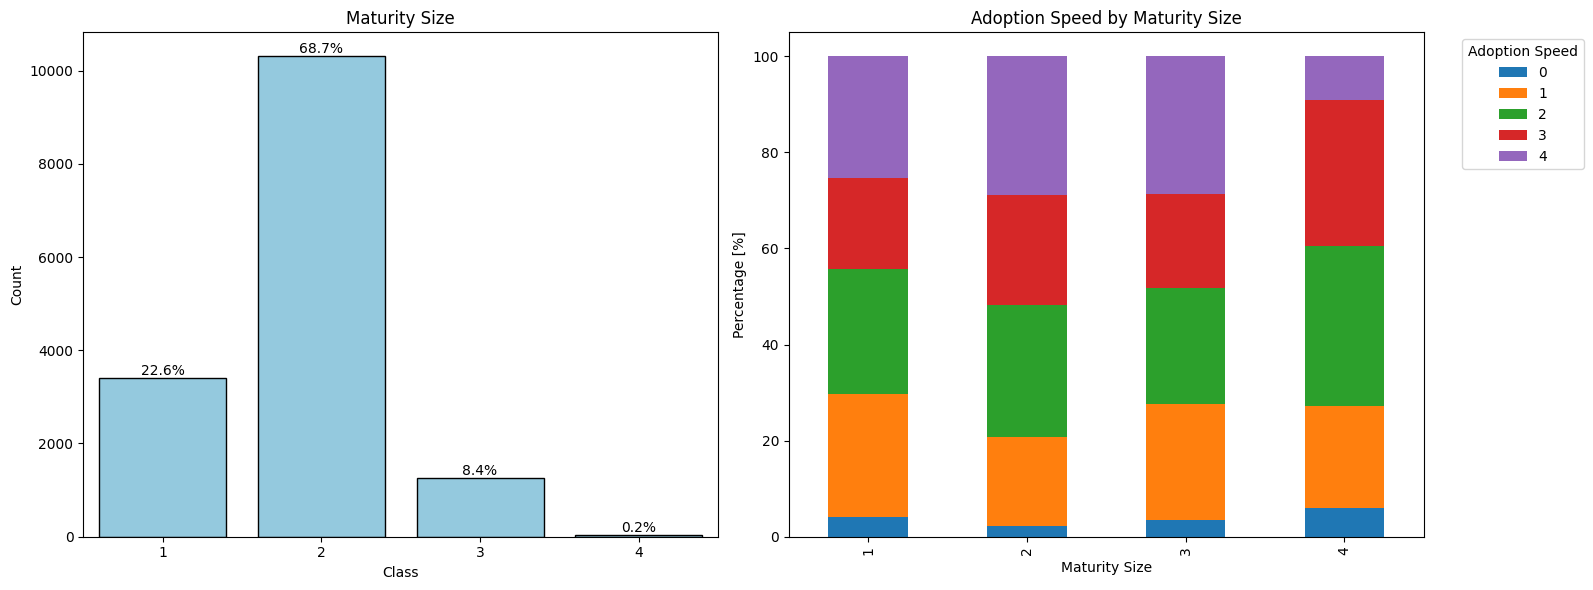


 AdoptionSpeed         0          1          2          3          4
MaturitySize                                                       
1              4.094256  25.625920  26.038292  18.880707  25.360825
2              2.193110  18.524988  27.530325  22.901504  28.850073
3              3.412698  24.126984  24.206349  19.682540  28.571429
4              6.060606  21.212121  33.333333  30.303030   9.090909

Coeficiente de Spearman: 0.0500, valor-p: 0.0000


In [31]:
plot_side_by_side(
    data=raw_df['MaturitySize'],
    var1=raw_df['MaturitySize'],
    var2=raw_df['AdoptionSpeed'],
    barplot_title="Maturity Size",
    barplot_xlab="Class",
    barplot_ylab="Count",
    crosstab_title="Adoption Speed by Maturity Size",
    crosstab_xlab="Maturity Size",
    crosstab_ylab="Percentage [%]",
    crosstab_leg="Adoption Speed"
)

corr, pval = spearmanr(raw_df["MaturitySize"], raw_df["AdoptionSpeed"])
print(f"\nCoeficiente de Spearman: {corr:.4f}, valor-p: {pval:.4f}")

- There are no missing values. Approximately 68.7% of the profiles correspond to medium-sized animals, 22.6% to small-sized animals, 8.4% to large-sized animals, and only 0.2% to very large-sized animals. It's worth noting that most profiles correspond to animals aged 12 months or younger, which means they have not yet reached their full adult size, so this attribute may not be accurate.
- Very large animals tend to be adopted more quickly, with only 9% remaining unadopted. However, since only 0.2% of profiles fall into this category, it is not representative. Small-sized animals tend to have a higher likelihood of being adopted and are adopted more quickly compared to medium and large-sized animals.
- The Spearman correlation coefficient is positive, and considering the p-value, it is statistically significant at any level of significance, indicating a positive correlation between the variables. However, given the coefficient's proximity to zero, the correlation is very weak.

##### Fur Length

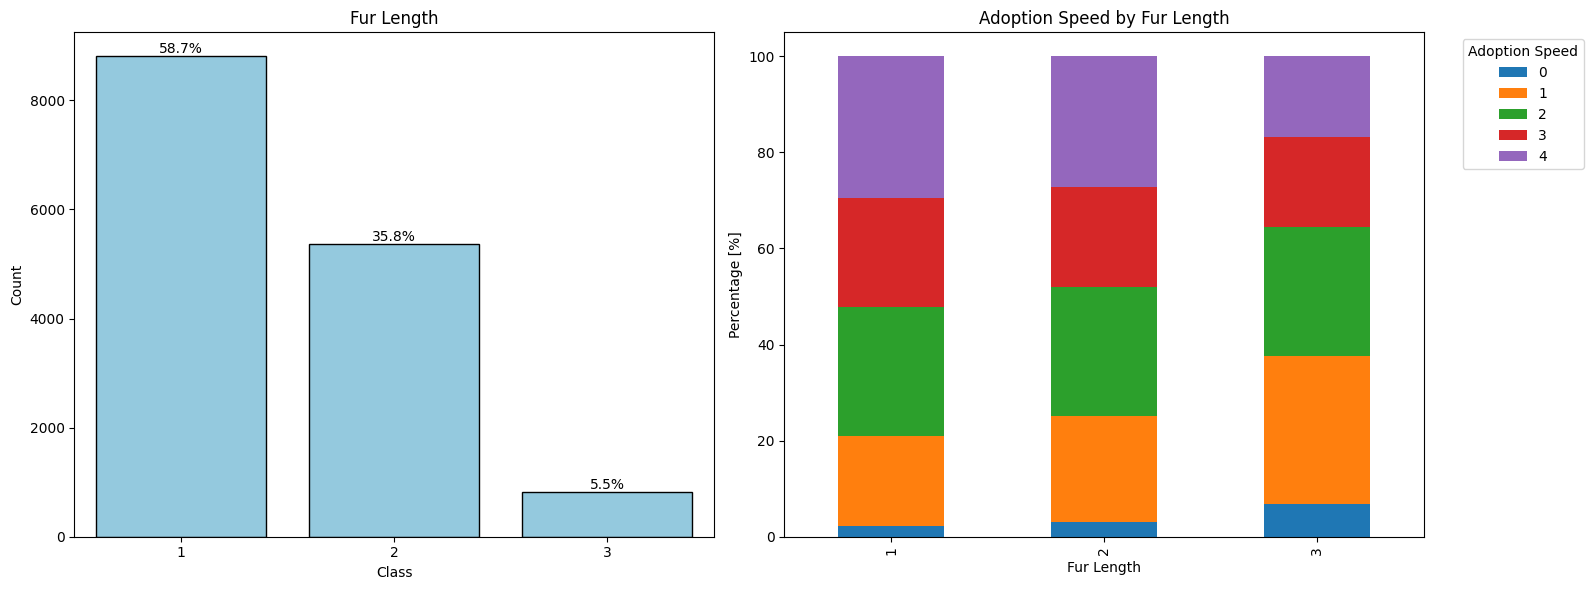


 AdoptionSpeed         0          1          2          3          4
FurLength                                                          
1              2.202543  18.721617  26.930064  22.638510  29.507266
2              2.984518  22.141392  26.935273  20.723746  27.215072
3              6.796117  30.825243  26.820388  18.689320  16.868932

Coeficiente de Spearman: -0.0798, valor-p: 0.0000


In [32]:
plot_side_by_side(
    data=raw_df['FurLength'],
    var1=raw_df['FurLength'],
    var2=raw_df['AdoptionSpeed'],
    barplot_title="Fur Length",
    barplot_xlab="Class",
    barplot_ylab="Count",
    crosstab_title="Adoption Speed by Fur Length",
    crosstab_xlab="Fur Length",
    crosstab_ylab="Percentage [%]",
    crosstab_leg="Adoption Speed"
)

corr, pval = spearmanr(raw_df["FurLength"], raw_df["AdoptionSpeed"])
print(f"\nCoeficiente de Spearman: {corr:.4f}, valor-p: {pval:.4f}")

- Approximately 58.7% of the profiles correspond to animals with short fur, 35.8% to animals with medium fur, and 5.5% to animals with long fur.
- Pets with long fur appear to have a higher likelihood of being adopted and tend to be adopted more quickly. There seems to be a preference for pets with medium fur over pets with short fur.
- The Spearman correlation coefficient is negative, and considering the p-value, it is statistically significant at any level of significance, indicating a negative correlation between the variables. However, given the coefficient's proximity to zero, the correlation is very weak.

##### Health

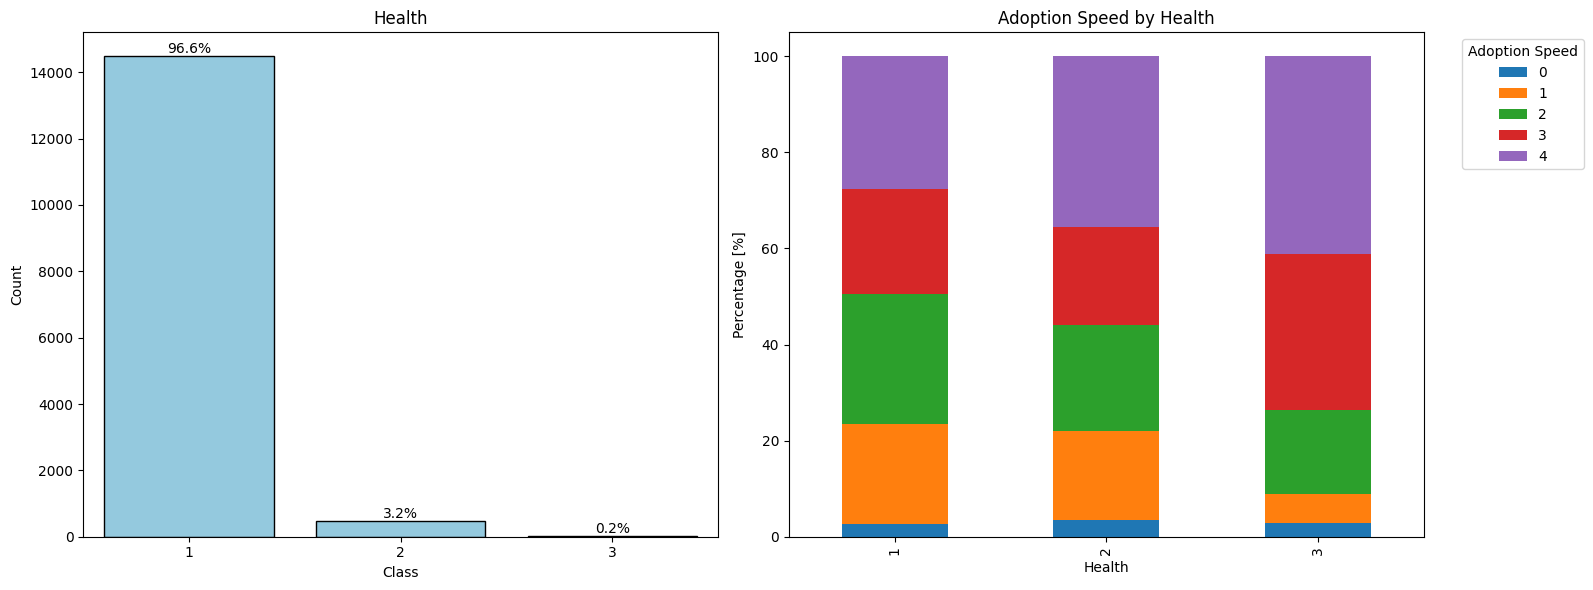


 AdoptionSpeed         0          1          2          3          4
Health                                                             
1              2.707556  20.714187  27.110098  21.757149  27.711010
2              3.534304  18.503119  22.037422  20.374220  35.550936
3              2.941176   5.882353  17.647059  32.352941  41.176471

Coeficiente de Spearman: 0.0284, valor-p: 0.0005


In [33]:
plot_side_by_side(
    data=raw_df['Health'],
    var1=raw_df['Health'],
    var2=raw_df['AdoptionSpeed'],
    barplot_title="Health",
    barplot_xlab="Class",
    barplot_ylab="Count",
    crosstab_title="Adoption Speed by Health",
    crosstab_xlab="Health",
    crosstab_ylab="Percentage [%]",
    crosstab_leg="Adoption Speed"
)

corr, pval = spearmanr(raw_df["Health"], raw_df["AdoptionSpeed"])
print(f"\nCoeficiente de Spearman: {corr:.4f}, valor-p: {pval:.4f}")

- Approximately 96.6% of the profiles correspond to healthy pets, 3.2% to pets with minor injuries, and only 0.2% to pets with severe injuries. It is worth noting that the health status of all profiles is known.
- Animals with severe injuries tend to have a lower likelihood of being adopted and take longer to be adopted. Although not statistically significant due to their small number, it is interesting to note that approximately 59% of them were adopted.
- The Spearman correlation coefficient is positive, and considering the p-value, it is statistically significant at conventional levels of significance, indicating a positive correlation between the variables. However, given the coefficient's proximity to zero, the correlation is very weak.

##### Quantity

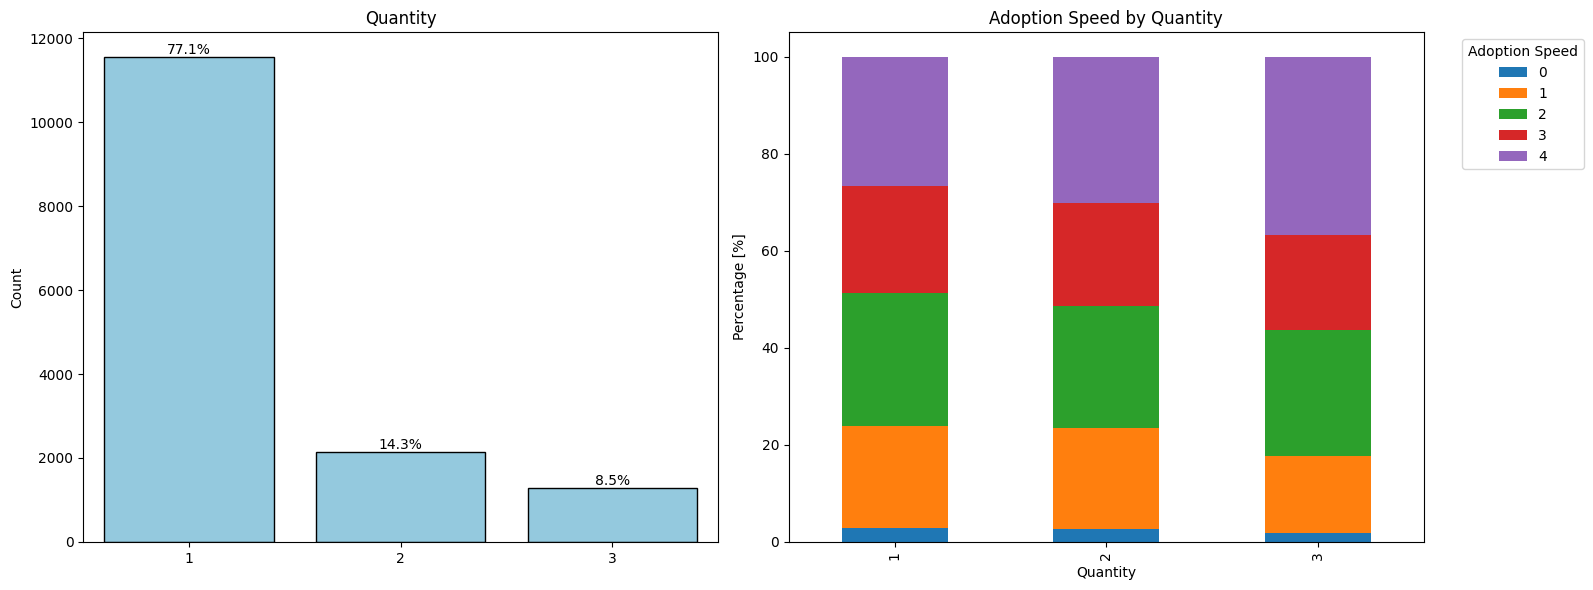


 AdoptionSpeed           0          1          2          3          4
ReducedQuantity                                                      
1                2.862084  21.089494  27.349762  22.066580  26.632080
2                2.560521  20.856611  25.279330  21.182495  30.121043
3                1.875000  15.859375  25.859375  19.687500  36.718750

Coeficiente de Spearman: 0.0532, valor-p: 0.0000


In [34]:
# if Quantity == 1 -> ReducedQuantity = 1
# if Quantity == 2 | Quantity == 3 -> ReducedQuantity = 2
# if Quantity >= 4 -> ReducedQuantity = 3
raw_df["ReducedQuantity"] = 1
mask = (raw_df['Quantity'] == 2) | (raw_df['Quantity'] == 3)
raw_df.loc[mask, 'ReducedQuantity'] = 2
mask = (raw_df['Quantity'] >= 4)
raw_df.loc[mask, 'ReducedQuantity'] = 3

plot_side_by_side(
    data=raw_df['ReducedQuantity'],
    var1=raw_df['ReducedQuantity'],
    var2=raw_df['AdoptionSpeed'],
    barplot_title="Quantity",
    barplot_xlab="",
    barplot_ylab="Count",
    crosstab_title="Adoption Speed by Quantity",
    crosstab_xlab="Quantity",
    crosstab_ylab="Percentage [%]",
    crosstab_leg="Adoption Speed"
)

corr, pval = spearmanr(raw_df["ReducedQuantity"], raw_df["AdoptionSpeed"])
print(f"\nCoeficiente de Spearman: {corr:.4f}, valor-p: {pval:.4f}")

- Approximately 77.1% of the profiles correspond to a single animal, 13.4% to two or three animals, and 8.5% to four or more animals. The maximum number of animals per profile is 20.
- Profiles with a single animal have a higher likelihood of being adopted and tend to be adopted more quickly.
- Profiles with two or three animals have a higher likelihood of being adopted and are adopted more quickly compared to profiles with four or more animals.
- The Spearman correlation coefficient is positive, and considering the p-value, it is statistically significant at conventional levels of significance, indicating a positive correlation between the variables. However, given the coefficient's proximity to zero, the correlation is very weak.

##### VideoAmt

In [35]:
raw_df['VideoAmt'].value_counts(normalize=True)

VideoAmt
0    0.961715
1    0.027813
2    0.006136
3    0.002401
4    0.001000
5    0.000467
6    0.000267
8    0.000133
7    0.000067
Name: proportion, dtype: float64

- Approximately 96.2% of the profiles do not have a video, 2.8% have one video, and 1% have one or more videos.
- The maximum number of videos per profile is 8.
- This variable does not appear to be very interesting.

##### PhotoAmt

In [36]:
print(raw_df['PhotoAmt'].describe())
print('\n', raw_df['PhotoAmt'].value_counts().head(10))

count    14993.000000
mean         3.889215
std          3.487810
min          0.000000
25%          2.000000
50%          3.000000
75%          5.000000
max         30.000000
Name: PhotoAmt, dtype: float64

 PhotoAmt
1.0    3075
2.0    2518
3.0    2511
5.0    2147
4.0    1881
6.0     621
7.0     432
0.0     341
8.0     314
9.0     231
Name: count, dtype: int64


- Approximately 2.3% of the profiles do not include photos.
- The maximum number of photos per profile is 30.
- Exhibits a positive skewness.

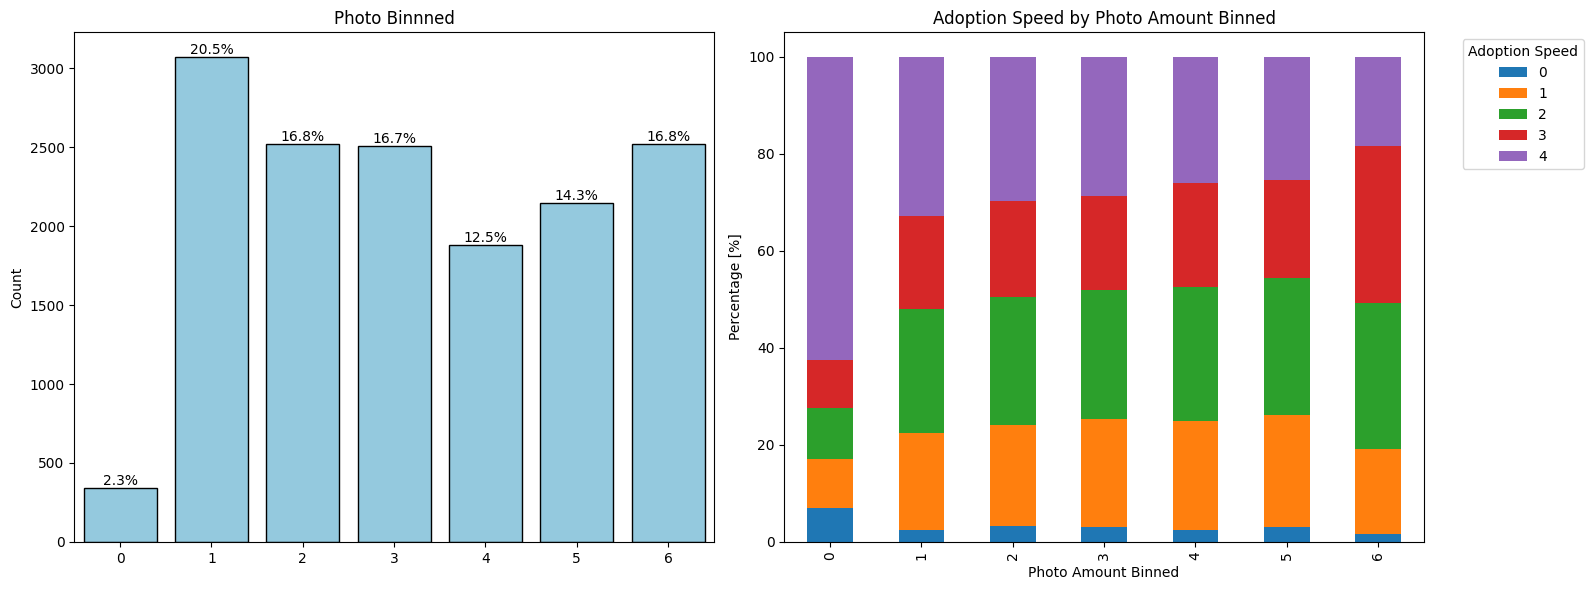


 AdoptionSpeed         0          1          2          3          4
PhotoBinned                                                        
0              7.038123   9.970674  10.557185   9.970674  62.463343
1              2.439024  20.000000  25.463415  19.252033  32.845528
2              3.296267  20.770453  26.409849  19.698173  29.825258
3              2.986858  22.341697  26.523297  19.394663  28.753485
4              2.392344  22.541201  27.644870  21.371611  26.049973
5              3.027480  23.055426  28.365161  20.167676  25.384257
6              1.706349  17.380952  30.079365  32.341270  18.492063

Coeficiente de Spearman: -0.0632, valor-p: 0.0000


In [37]:
#Profiles with 6 or more photos are grouped together
raw_df['PhotoBinned'] = raw_df['PhotoAmt']
mask = (raw_df['PhotoAmt'] >= 6)
raw_df.loc[mask, 'PhotoBinned'] = 6
raw_df['PhotoBinned'] = raw_df['PhotoBinned'].astype(int)

plot_side_by_side(
    data=raw_df['PhotoBinned'],
    var1=raw_df['PhotoBinned'],
    var2=raw_df['AdoptionSpeed'],
    barplot_title="Photo Binnned",
    barplot_xlab="",
    barplot_ylab="Count",
    crosstab_title="Adoption Speed by Photo Amount Binned",
    crosstab_xlab="Photo Amount Binned",
    crosstab_ylab="Percentage [%]",
    crosstab_leg="Adoption Speed"
)

corr, pval = spearmanr(raw_df["PhotoBinned"], raw_df["AdoptionSpeed"])
print(f"\nCoeficiente de Spearman: {corr:.4f}, valor-p: {pval:.4f}")

- Having photos increases the likelihood of adoption.
- Interestingly, profiles without photos have a higher percentage of cases where the animals were adopted on the same day the profile was published, but they also have the highest percentage of animals that were not adopted. However, this is likely influenced by the smaller sample size in this group.
- The Spearman correlation coefficient is negative, and considering the p-value, it is statistically significant at conventional levels, indicating a negative correlation between the variables. However, given the coefficient’s proximity to zero, the correlation is very weak. Nonetheless, this reinforces the idea that having more photos increases the likelihood of adoption.

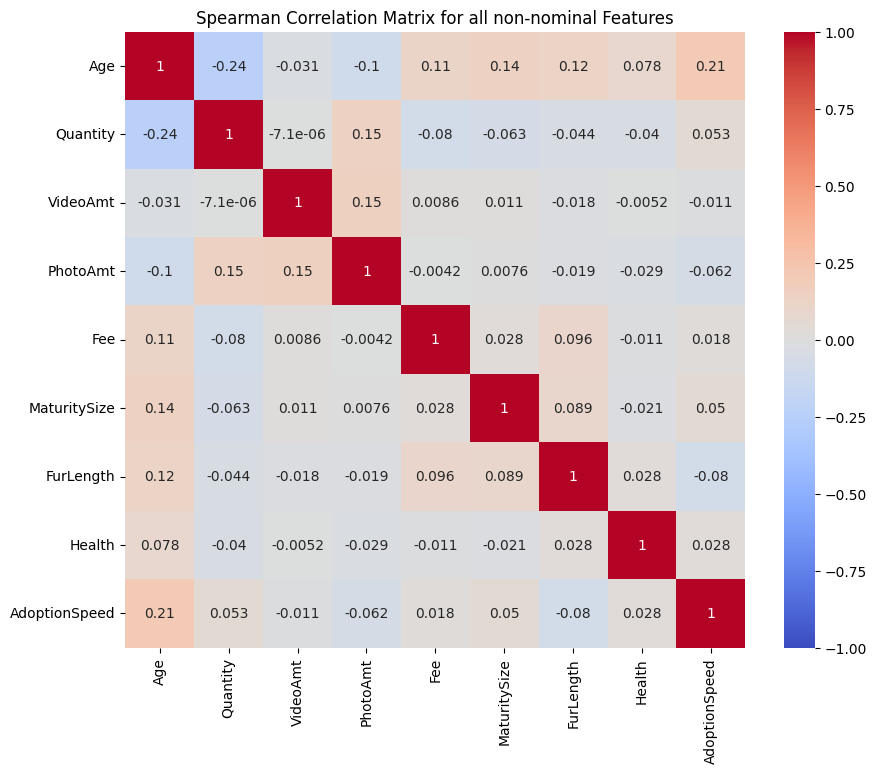

In [38]:
non_nominal_data = ['Age', 'Quantity', 'VideoAmt', 'PhotoAmt', 'Fee', 'MaturitySize', 'FurLength', 'Health']

correlation_matrix = raw_df[non_nominal_data + ['AdoptionSpeed']].corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", cbar=True, vmin=-1, vmax=1)
plt.title("Spearman Correlation Matrix for all non-nominal Features")
plt.show()

- The most noticeable correlation in the matrix is between Age and AdoptionSpeed.
- The weak correlations overall suggest that adoption speed may be influenced by other factors not captured in this correlation matrix, or that the relationships between these variables and adoption speed are complex and not easily discernible through simple correlation analysis.

## 0.3. Preprocessing Data

In [39]:
raw_df.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PhotoAmt', 'AdoptionSpeed', 'AgeBinned',
       'PureBreed', 'TopState', 'ColorsCount', 'PayFee', 'ReducedQuantity',
       'PhotoBinned'],
      dtype='object')

In [40]:
cols_to_drop = ['Name',
                'Age',
                'Breed1', 'Breed2',
                'Color1', 'Color2', 'Color3',
                'Health',
                'Quantity',
                'Fee',
                'State',
                'RescuerID',
                'VideoAmt',
                'Description',
                'PhotoAmt',
                'AdoptionSpeed']

In [41]:
X = raw_df.drop(columns = cols_to_drop, inplace=False).copy()
X.head(2)

,Type,Gender,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,AgeBinned,PureBreed,TopState,ColorsCount,PayFee,ReducedQuantity,PhotoBinned
PetID,,,,,,,,,,,,,,
86e1089a3,2,1,1,1,2,2,2,3,0,1,2,1,1,1
6296e909a,2,1,2,2,3,3,3,0-2,0,2,2,0,1,2


In [42]:
nominal_cols = ['Type', 'Gender', 'Vaccinated', 'Dewormed', 'Sterilized', 'AgeBinned', 'TopState']
ordinal_cols = ['MaturitySize', 'FurLength', 'ColorsCount', 'ReducedQuantity', 'PhotoBinned']

X_enc_sca = pd.get_dummies(X, columns= nominal_cols, drop_first=True, dtype=int)

min_max_scaler = preprocessing.MinMaxScaler()
X_enc_sca[ordinal_cols] = min_max_scaler.fit_transform(X_enc_sca[ordinal_cols])

X_enc_sca.describe()

,MaturitySize,FurLength,PureBreed,ColorsCount,PayFee,ReducedQuantity,PhotoBinned,Type_2,Gender_2,Gender_3,Vaccinated_2,Vaccinated_3,Dewormed_2,Dewormed_3,Sterilized_2,Sterilized_3,AgeBinned_3,AgeBinned_4-6,AgeBinned_7-12,AgeBinned_13-36,AgeBinned_37+,TopState_2,TopState_3,TopState_4,TopState_5
count,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000
mean,0.287334,0.233742,0.117188,0.497265,0.155406,0.157007,0.544954,0.457614,0.485360,0.145401,0.482025,0.124591,0.321150,0.118789,0.672114,0.121056,0.131128,0.150870,0.133195,0.121657,0.063896,0.256453,0.056226,0.033816,0.072300
std,0.182653,0.299535,0.321655,0.384367,0.362303,0.310717,0.304205,0.498217,0.499802,0.352517,0.499693,0.330266,0.466934,0.323551,0.469459,0.326204,0.337551,0.357934,0.339797,0.326900,0.244577,0.436689,0.230366,0.180761,0.258993
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.333333,0.000000,0.000000,0.500000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.333333,0.500000,0.000000,1.000000,0.000000,0.000000,0.833333,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Task 1 (Supervised Learning) - Predicting Adoption and Adoption Speed

In [43]:
def model_evaluation(model, param_grid, X_train, X_test, y_train, y_test, score):
    
    gs = GridSearchCV(estimator=model,
                      param_grid=param_grid,
                      scoring=score,
                      cv=2,
                      n_jobs=-1)

    cv_results = cross_validate(estimator = gs,
                                X = X_train,
                                y = y_train,
                                scoring = {'f1_score':score, 'acc': 'accuracy'},
                                cv=5,
                                n_jobs=-1,
                                return_train_score=True)

    print('Train F1-Score: %.3f +/- %.3f' % (np.mean(cv_results['train_f1_score']), np.std(cv_results['train_f1_score'])))
    print('Test F1-Score: %.3f +/- %.3f' % (np.mean(cv_results['test_f1_score']), np.std(cv_results['test_f1_score'])))
    print('\nTrain Accuracy: %.3f +/- %.3f' % (np.mean(cv_results['train_acc']), np.std(cv_results['train_acc'])))
    print('Test Accuracy: %.3f +/- %.3f' % (np.mean(cv_results['test_acc']), np.std(cv_results['test_acc'])))

    gs.fit(X_train, y_train)
    best_model = gs.best_estimator_
    print('\n', gs.best_params_, '\n')
    
    y_test_pred = best_model.predict(X_test)

    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.show()

    print('\n' ,classification_report(y_test, y_test_pred))

    return best_model

### Binary Classification

In [44]:
Y = raw_df['AdoptionSpeed'].map(lambda x: int(x < 4))
Y.value_counts(normalize=True)

AdoptionSpeed
1    0.720069
0    0.279931
Name: proportion, dtype: float64

Since the goal is to minimize animal suffering and reduce the number of animals that are ultimately euthanized, the model should accurately predict class 0, i.e., animals that are not adopted. By predicting animals that are unlikely to be adopted, strategies can be developed to increase their chances of adoption. Therefore, Recall for class 0 is chosen as a metric to evaluate the models. However, it is also important not to wrongly predict class 0, as this would allocate resources to animals that don't require them, given that they already have a higher likelihood of being adopted. Thus, Precision for class 0 must also be taken into account.

Therefore, we opt to use the F1-Score for class 0 as the evaluation metric, as it strikes a balance between Precision and Recall.

$$
F1 \, \text{(Class 0)} = 2 \times \frac{\text{Precision (Class 0)} \times \text{Recall (Class 0)}}{\text{Precision (Class 0)} + \text{Recall (Class 0)}}
$$

In [45]:
f1_class0_scorer = make_scorer(f1_score, average='binary', pos_label=0)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_enc_sca, Y, test_size=0.2, stratify=Y, random_state=seed)
print(pd.Series(y_train).value_counts(normalize=True))

AdoptionSpeed
1    0.72011
0    0.27989
Name: proportion, dtype: float64


In [47]:
rus = RandomUnderSampler(sampling_strategy='not minority', random_state=seed, replacement=False)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)
#print(pd.Series(y_train_resampled).value_counts(normalize=True))

In [48]:
# Baseline Model
# The baseline model predicts that all pets are not adopted

print("Baseline Model - Class 0 F1-Score:", round(2*(0.27989*1)/(0.27989+1), 4))
print("Baseline Model - Accuracy:", round(0.27989,4))

Baseline Model - Class 0 F1-Score: 0.4374
Baseline Model - Accuracy: 0.2799


#### Decision Trees

Train F1-Score: 0.557 +/- 0.037
Test F1-Score: 0.508 +/- 0.006

Train Accuracy: 0.690 +/- 0.032
Test Accuracy: 0.654 +/- 0.012

 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10} 



c:\Users\duart\miniconda3\envs\churn\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


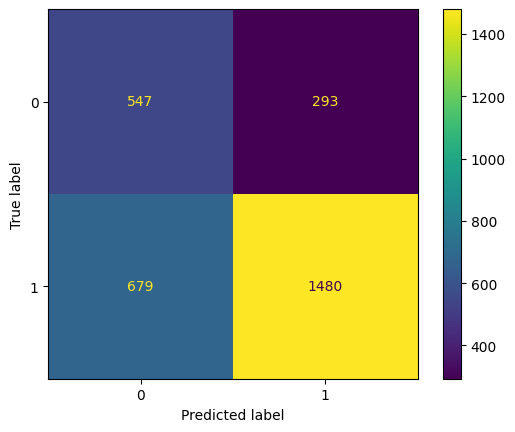


               precision    recall  f1-score   support

           0       0.45      0.65      0.53       840
           1       0.83      0.69      0.75      2159

    accuracy                           0.68      2999
   macro avg       0.64      0.67      0.64      2999
weighted avg       0.73      0.68      0.69      2999



In [49]:
model = tree.DecisionTreeClassifier(random_state=seed)
param_grid = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}

dt = model_evaluation(model, param_grid, X_train, X_test, y_train, y_test, f1_class0_scorer)

- There is a significant improvement in the Class 0 F1-Score, increasing from 0.437 to 0.508, and the accuracy has more than doubled compared to the baseline model. This improvement is expected, as the baseline model does not take the features' information into account, limiting its predictive capability.

- The slightly higher training scores are expected and within reasonable bounds, which suggests that the model generalizes well and is not overfitting to the training data.
- The small standard deviations (±0.037 for Train F1-Score and ±0.006 for Test F1-Score) indicate consistent performance across cross-validation folds. This suggests that the model's performance is stable and not overly sensitive to the specific train-test splits.

- Regarding the hyperparameters:
    - The "max_depth" hyperparameter controls the number of levels from the root of the tree to the deepest leaf nodes. When set to None, there is no limit on the tree's depth, allowing it to grow until all leaves are pure, however, this can lead to overfitting. Limiting the depth of the tree to 10 strikes a balance between complexity and generalization, preventing overfitting while still capturing important patterns.
  
    - The "min_samples_split" hyperparameter specifies the minimum number of samples required to split an internal node. For example, with a value of 10, a node will only be split if it contains at least 10 samples. Higher values can reduce overfitting by limiting the tree's growth, but they may also cause underfitting if too restrictive.
  
    - The "min_samples_leaf" hyperparameter determines the minimum number of samples a leaf node must contain. For instance, with a value of 2, leaf nodes can consist of at least 2 samples. Higher values reduce overfitting by ensuring leaves represent larger subsets of data but might lead to underfitting if set too high.
  
    - The "criterion" hyperparameter defines the function used to evaluate the quality of splits. The use of entropy as the splitting criterion suggests that the model benefits from maximizing information gain, possibly due to complex relationships in the data.
  
    - The "max_features" hyperparameter determines the number of features to consider when making each split. If set to None, all features are used. The value "sqrt" uses the square root of the total number of features, while "log2" uses the base-2 logarithm of the total number of features. Reducing the number of features considered per split can help prevent overfitting, but it might also lead to a loss of critical information. Using all features at each split suggests that the full feature set provides valuable information for splitting, and reducing the number of features might have led to a loss in predictive power.
  
    - The "class_weight" hyperparameter adjusts the weight assigned to each class, which is particularly useful in datasets with imbalanced class distributions, like this one. If set to None, all classes are given equal weight. If set to "balanced", the weights are automatically adjusted inversely proportional to the frequency of each class.

In [50]:
feature_importances = dt.feature_importances_
important_features = sorted(zip(X_train.columns, feature_importances), key=lambda x: x[1], reverse=True)
for feature, importance in important_features:
    print(f"{feature}: {importance:.4f}")

Sterilized_2: 0.1695
PhotoBinned: 0.1316
MaturitySize: 0.0656
ReducedQuantity: 0.0630
FurLength: 0.0549
PureBreed: 0.0531
Type_2: 0.0528
AgeBinned_4-6: 0.0485
AgeBinned_7-12: 0.0464
AgeBinned_13-36: 0.0391
ColorsCount: 0.0258
Gender_2: 0.0251
AgeBinned_3: 0.0243
PayFee: 0.0236
TopState_4: 0.0216
TopState_3: 0.0212
Vaccinated_3: 0.0202
TopState_5: 0.0200
Dewormed_2: 0.0199
TopState_2: 0.0178
Vaccinated_2: 0.0164
AgeBinned_37+: 0.0141
Gender_3: 0.0106
Sterilized_3: 0.0100
Dewormed_3: 0.0049


- The most important features are Sterilized_2 (16.95%) and PhotoBinned (13.16%), which together contribute significantly to the model's predictive power.
- Features like MaturitySize (6.56%), ReducedQuantity (6.30%), FurLength (5.49%), PureBreed (5.31%), and Type_2 (5.28%) provide moderate contributions.
- Age-related binned features, such as AgeBinned_4-6 (4.85%), AgeBinned_7-12 (4.64%), and AgeBinned_13-36 (3.91%), collectively contribute to the model. This indicates that age grouping is informative, but no single age range dominates the predictions.

#### Naive Bayes

Train F1-Score: 0.461 +/- 0.003
Test F1-Score: 0.453 +/- 0.010

Train Accuracy: 0.689 +/- 0.002
Test Accuracy: 0.684 +/- 0.007

 {} 



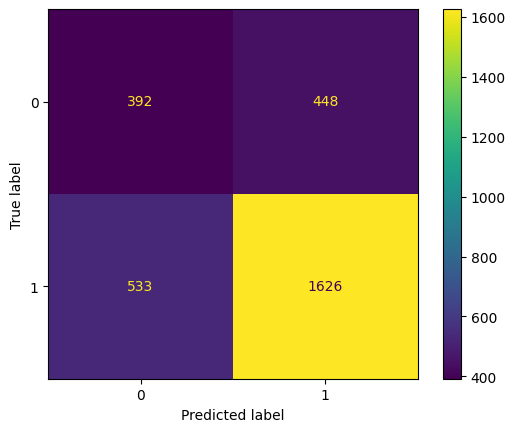


               precision    recall  f1-score   support

           0       0.42      0.47      0.44       840
           1       0.78      0.75      0.77      2159

    accuracy                           0.67      2999
   macro avg       0.60      0.61      0.61      2999
weighted avg       0.68      0.67      0.68      2999



In [51]:
model = GaussianNB()
param_grid = {}

gnb = model_evaluation(model, param_grid, X_train, X_test, y_train, y_test, f1_class0_scorer)

- The Naive Bayes model improves slightly over the baseline in terms of Class 0 F1-Score (from 0.437 to 0.453 on the test set). However, its performance is notably lower than the Decision Tree model.
- This could be attributed to the simplistic assumptions of Naive Bayes. Specifically, the Gaussian Naive Bayes model assumes that the variables follow a normal distribution, making it particularly suitable for continuous variables, which is not the case.
- The training and test scores are nearly identical, it the seems that the model is too simple to capture the complexity of the data and is likely underfitting.

#### KNN

Train F1-Score: 0.797 +/- 0.086
Test F1-Score: 0.643 +/- 0.012

Train Accuracy: 0.792 +/- 0.089
Test Accuracy: 0.634 +/- 0.006

 {'metric': 'manhattan', 'n_neighbors': 13, 'weights': 'uniform'} 



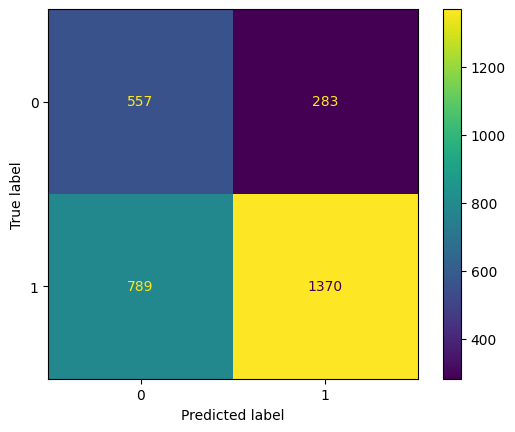


               precision    recall  f1-score   support

           0       0.41      0.66      0.51       840
           1       0.83      0.63      0.72      2159

    accuracy                           0.64      2999
   macro avg       0.62      0.65      0.61      2999
weighted avg       0.71      0.64      0.66      2999



In [52]:
model = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [3,5,7,9,11,13,15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan'],
}

knn = model_evaluation(model, param_grid, X_train_resampled, X_test, y_train_resampled, y_test, f1_class0_scorer)

- The "n_neighbors" hyperparameter specifies the number of neighbors considered when predicting a new data point. Lower values provide greater flexibility, which can capture fine-grained patterns but may lead to overfitting. Conversely, higher values result in a smoother, more stable model that generalizes better but may fail to detect certain local patterns.

- The "weights" hyperparameter determines the influence of each neighbor. When set to "uniform", all neighbors contribute equally to the prediction. In contrast, when set to "distance", closer neighbors are given more weight, while those further away contribute less.

- Finally, the "metric" hyperparameter defines how the distance between points is calculated. In this analysis, both Euclidean distance and Manhattan distance were tested.

- The significant gap between the training and test scores indicates potential overfitting. The model performs very well on the resampled training data but struggles to generalize to unseen data. This issue becomes even more pronounced when undersampling is not applied.

  
- In the final classification report, where the model was evaluated on the test set, the Class 0 F1-Score is 0.50, which reflects the expected performance on unseen data. This result is notably lower than the validation F1-Score of 0.643, highlighting a potential drop in generalization performance.
- This model outperforms both the baseline model and the Naive Bayes model in predicting Class 0, however, it falls slightly short of the Decision Tree model. Additionally, when considering overall accuracy, this model performs significantly worse than the Decision Tree model, indicating its limitations in balancing performance across both classes.

#### Logistic Regression

Train F1-Score: 0.532 +/- 0.002
Test F1-Score: 0.530 +/- 0.005

Train Accuracy: 0.669 +/- 0.001
Test Accuracy: 0.667 +/- 0.009

 {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'} 



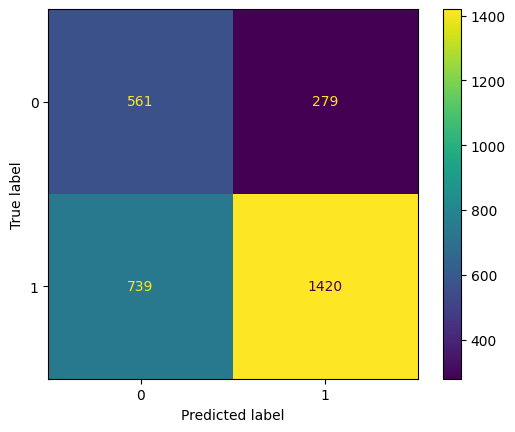


               precision    recall  f1-score   support

           0       0.43      0.67      0.52       840
           1       0.84      0.66      0.74      2159

    accuracy                           0.66      2999
   macro avg       0.63      0.66      0.63      2999
weighted avg       0.72      0.66      0.68      2999



In [53]:
model = LogisticRegression(random_state=seed)

param_grid = [
    {'solver': ['lbfgs'], 'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'max_iter': [100, 200, 500], 'class_weight': [None, 'balanced']},
    {'solver': ['liblinear'], 'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'max_iter': [100, 200, 500], 'class_weight': [None, 'balanced']},
    {'solver': ['saga'], 'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'max_iter': [100, 200, 500], 'class_weight': [None, 'balanced']}
]

lgr = model_evaluation(model, param_grid, X_train, X_test, y_train, y_test, f1_class0_scorer)

- Both the Class 0 F1 score and the accuracy are quite similar between the training and test sets, indicating that the model generalizes well on unseen data. Additionally, the Logistic Regression model outperforms the Decision Tree model, with the Class 0 F1-Score improving from 0.508 to 0.530. There was also a sligth increase in accuracy.

- The small standard deviations (±0.002 for Train F1-Score and ±0.005 for Test F1-Score) indicate consistent performance across cross-validation folds. This suggests that the model's performance is stable and not overly sensitive to the specific train-test splits.

- The "solver" hyperparameter determines the algorithm used to optimize the loss function.
- The "penalty" hyperparameter specifies the type of regularization applied to the model. Two options were analysed, l1 corresponds to Lasso Regularization and l2 to Ridge Regularization. 
- The "C" hyperparameter is the inverse of regularization strength. Small values (e.g., 0.1) indicate stronger regularization, while large values (e.g., 100) indicate weaker regularization.
- The "max_iter" hyperparameter specifies the maximum number of iterations allowed for the solver to converge.
- The "class_weight" hyperparameter adjusts the importance of classes when computing the loss function, especially useful for imbalanced datasets.

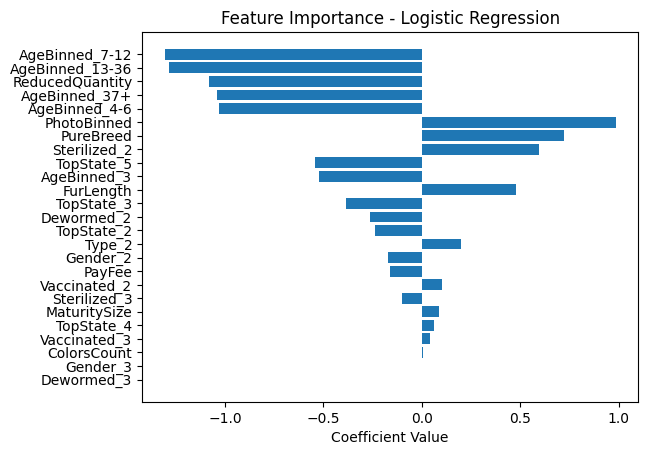

In [54]:
coefficients = lgr.coef_[0]
sorted_idx = np.argsort(np.abs(coefficients))
plt.barh(X_train.columns[sorted_idx], coefficients[sorted_idx])
plt.xlabel('Coefficient Value')
plt.title('Feature Importance - Logistic Regression')
plt.show()

- The coefficients of the logistic regression model represent the log-odds ratio associated with each feature, providing insights into the relationship between the features and the target variable. 
- Larger absolute values of coefficients indicate a stronger influence of that feature on the model's predictions. Features with smaller coefficients (close to 0) have little to no impact.
- The features with most impact are "Age" related features, "ReducedQuantity", "PhotoBinned", and "PureBreed".

#### SVM

In [55]:
# model = SVC(random_state=seed)

# param_grid = {
#     'C': [0.01, 0.1, 1, 10, 100],
#     'kernel': ['linear', 'rbf'],
#     'gamma': ['scale', 'auto'],
#     'class_weight': [None, 'balanced']
# }

# svm = model_evaluation(model, param_grid, X_train, X_test, y_train, y_test, f1_class0_scorer)

Train F1-Score: 0.560 +/- 0.004
Test F1-Score: 0.542 +/- 0.006

Train Accuracy: 0.695 +/- 0.004
Test Accuracy: 0.682 +/- 0.008

 {'C': 10, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf'} 



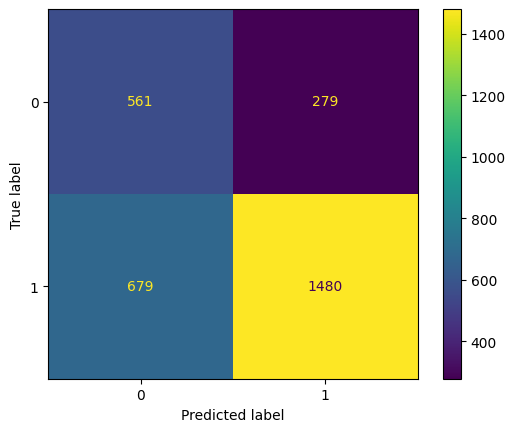


               precision    recall  f1-score   support

           0       0.45      0.67      0.54       840
           1       0.84      0.69      0.76      2159

    accuracy                           0.68      2999
   macro avg       0.65      0.68      0.65      2999
weighted avg       0.73      0.68      0.69      2999



In [56]:
model = SVC(random_state=seed)

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf'],
    'gamma': ['auto'],
    'class_weight': ['balanced']
}

svm = model_evaluation(model, param_grid, X_train, X_test, y_train, y_test, f1_class0_scorer)

- The SVM outperforms the Logistic Regression model, with the Class 0 F1-Score improving from 0.530 to 0.542. There was also a sligth increase in accuracy.

- The slightly higher training scores are expected and within reasonable bounds, which suggests that the model generalizes well and is not overfitting to the training data.
- The small standard deviations (±0.016 for Train F1-Score and ±0.005 for Test F1-Score) indicate consistent performance across cross-validation folds. This suggests that the model's performance is stable and not overly sensitive to the specific train-test splits.

- Regarding the hyperparameters:
    - C=10: A relatively large regularization parameter allows the model to focus on minimizing the error on the training set, balancing bias and variance.
    - kernel='rbf': The radial basis function kernel enables the model to capture non-linear patterns in the data.
    - gamma='auto': Automatically scales the kernel coefficient based on the number of features.
    - class_weight='balanced': Adjusts the class weights to address the class imbalance in the dataset.

#### Random Forest

Train F1-Score: 0.668 +/- 0.015
Test F1-Score: 0.544 +/- 0.004

Train Accuracy: 0.786 +/- 0.010
Test Accuracy: 0.705 +/- 0.008

 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2} 



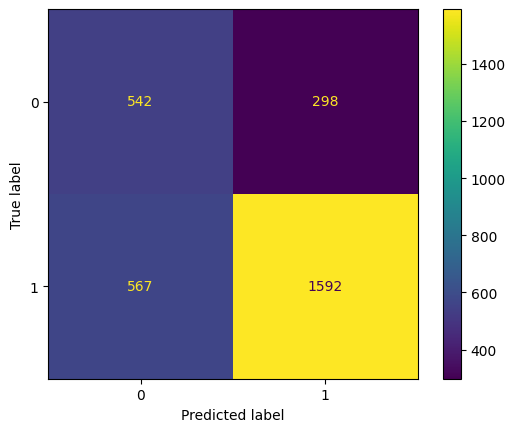


               precision    recall  f1-score   support

           0       0.49      0.65      0.56       840
           1       0.84      0.74      0.79      2159

    accuracy                           0.71      2999
   macro avg       0.67      0.69      0.67      2999
weighted avg       0.74      0.71      0.72      2999



In [57]:
model = RandomForestClassifier(random_state=seed)

param_grid = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}

rft = model_evaluation(model, param_grid, X_train, X_test, y_train, y_test, f1_class0_scorer)

- The Random Forest model outperforms all the previous models in terms of both Class 0 F1-Score and accuracy. With a Class 0 F1-Score of 0.544 and an accuracy of 0.705 indicating strong overall predictive performance.

- The results demonstrate that Random Forest's ensemble learning approach, which aggregates predictions from multiple decision trees, effectively captures intricate relationships within the data.

### Predicting AdoptionSpeed (5 classes - multiclass classification)

In the case of classifying adoption speed, the profiles are well distributed across the classes, with the exception of Class 0, which represents only 2.7% of the total number of profiles.

Therefore, the Weighted F1-Score is chosen as the evaluation metric for the models, where each class score is weighted according to the size of the respective class.

$$
F1_{\text{weighted}} = \frac{\sum_{c=1}^{N} w_c \cdot F1_c}{\sum_{c=1}^{N} w_c}
$$

In [58]:
f1_scorer = make_scorer(f1_score, average='weighted')

In [59]:
Y = raw_df['AdoptionSpeed'].copy()

In [60]:
#the split is stratified (maintaining class proportions in train and test)
X_train, X_test, y_train, y_test = train_test_split(X_enc_sca, Y, test_size=0.2, random_state=seed, stratify=Y)
print(pd.Series(y_train).value_counts(normalize=True))

AdoptionSpeed
4    0.279890
2    0.269301
3    0.217359
1    0.206103
0    0.027347
Name: proportion, dtype: float64


#### Decision Tree

Train F1-Score: 0.439 +/- 0.007
Test F1-Score: 0.341 +/- 0.013

Train Accuracy: 0.450 +/- 0.005
Test Accuracy: 0.354 +/- 0.010

 {'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5} 



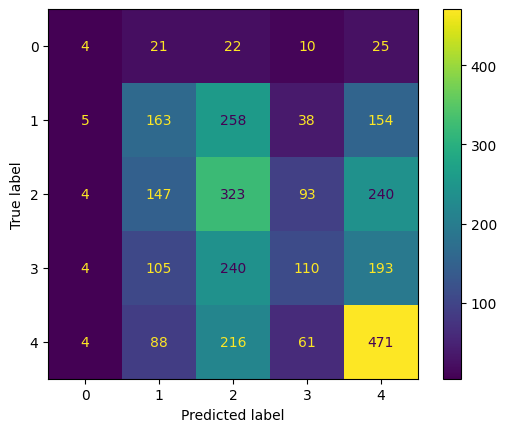


               precision    recall  f1-score   support

           0       0.19      0.05      0.08        82
           1       0.31      0.26      0.29       618
           2       0.31      0.40      0.35       807
           3       0.35      0.17      0.23       652
           4       0.43      0.56      0.49       840

    accuracy                           0.36      2999
   macro avg       0.32      0.29      0.29      2999
weighted avg       0.35      0.36      0.34      2999



In [61]:
model = tree.DecisionTreeClassifier(random_state=seed)
param_grid = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}

dt_multi = model_evaluation(model, param_grid, X_train, X_test, y_train, y_test, f1_scorer)

#### Naive Bayes

Train F1-Score: 0.342 +/- 0.004
Test F1-Score: 0.336 +/- 0.009

Train Accuracy: 0.350 +/- 0.001
Test Accuracy: 0.344 +/- 0.009

 {} 



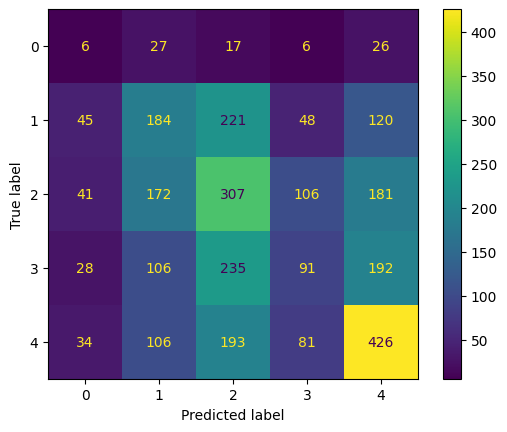


               precision    recall  f1-score   support

           0       0.04      0.07      0.05        82
           1       0.31      0.30      0.30       618
           2       0.32      0.38      0.34       807
           3       0.27      0.14      0.18       652
           4       0.45      0.51      0.48       840

    accuracy                           0.34      2999
   macro avg       0.28      0.28      0.27      2999
weighted avg       0.34      0.34      0.33      2999



In [62]:
model = GaussianNB()
param_grid = {}

gnb_multi = model_evaluation(model, param_grid, X_train, X_test, y_train, y_test, f1_scorer)

#### KNN

Train F1-Score: 0.526 +/- 0.183
Test F1-Score: 0.341 +/- 0.005

Train Accuracy: 0.534 +/- 0.179
Test Accuracy: 0.350 +/- 0.005

 {'metric': 'euclidean', 'n_neighbors': 21, 'weights': 'distance'} 



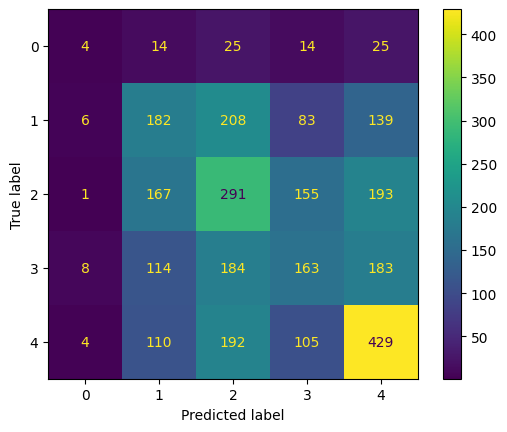


               precision    recall  f1-score   support

           0       0.17      0.05      0.08        82
           1       0.31      0.29      0.30       618
           2       0.32      0.36      0.34       807
           3       0.31      0.25      0.28       652
           4       0.44      0.51      0.47       840

    accuracy                           0.36      2999
   macro avg       0.31      0.29      0.29      2999
weighted avg       0.35      0.36      0.35      2999



In [63]:
model = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [3,5,7,9,11,13,15,17,19,21],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan'],
}

knn_multi = model_evaluation(model, param_grid, X_train, X_test, y_train, y_test, f1_scorer)

#### Logistic Regression

Train F1-Score: 0.357 +/- 0.003
Test F1-Score: 0.348 +/- 0.010

Train Accuracy: 0.374 +/- 0.010
Test Accuracy: 0.365 +/- 0.013

 {'C': 0.01, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l2', 'solver': 'liblinear'} 



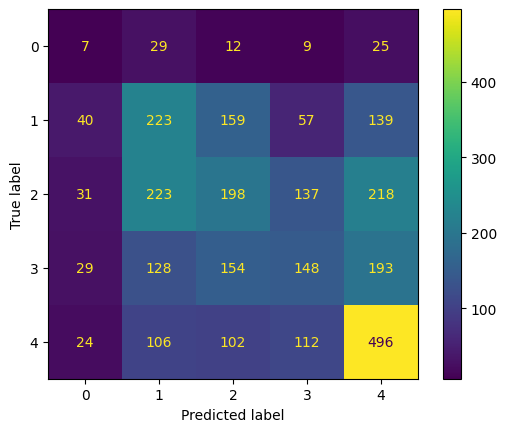


               precision    recall  f1-score   support

           0       0.05      0.09      0.07        82
           1       0.31      0.36      0.34       618
           2       0.32      0.25      0.28       807
           3       0.32      0.23      0.27       652
           4       0.46      0.59      0.52       840

    accuracy                           0.36      2999
   macro avg       0.29      0.30      0.29      2999
weighted avg       0.35      0.36      0.35      2999



In [64]:
model = LogisticRegression(random_state=seed)

param_grid = [
    {'solver': ['lbfgs'], 'penalty': ['l2'], 'C': [0.01, 0.1, 1, 10], 'max_iter': [500, 1000], 'class_weight': [None, 'balanced']},
    {'solver': ['liblinear'], 'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10], 'max_iter': [500,1000], 'class_weight': [None, 'balanced']},
    {'solver': ['saga'], 'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10], 'max_iter': [500,1000], 'class_weight': [None, 'balanced']}
]

lgr_multi = model_evaluation(model, param_grid, X_train, X_test, y_train, y_test, f1_scorer)

#### SVM

Train F1-Score: 0.369 +/- 0.014
Test F1-Score: 0.337 +/- 0.006

Train Accuracy: 0.363 +/- 0.013
Test Accuracy: 0.328 +/- 0.006

 {'C': 1, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf'} 



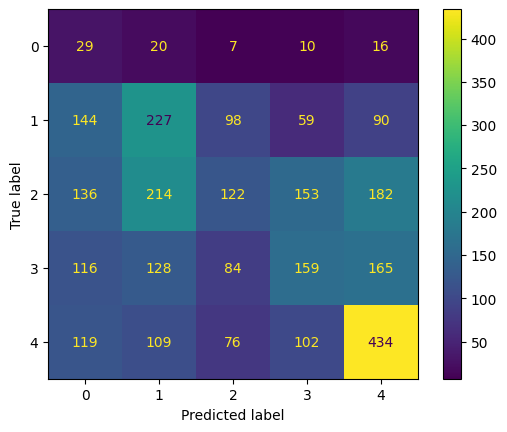


               precision    recall  f1-score   support

           0       0.05      0.35      0.09        82
           1       0.33      0.37      0.34       618
           2       0.32      0.15      0.20       807
           3       0.33      0.24      0.28       652
           4       0.49      0.52      0.50       840

    accuracy                           0.32      2999
   macro avg       0.30      0.33      0.28      2999
weighted avg       0.36      0.32      0.33      2999



In [65]:
model = SVC(random_state=seed)

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf'],
    'gamma': ['auto'],
    'class_weight': ['balanced']
}

svm_multi = model_evaluation(model, param_grid, X_train, X_test, y_train, y_test, f1_scorer)

#### Random Forest

Train F1-Score: 0.603 +/- 0.063
Test F1-Score: 0.359 +/- 0.007

Train Accuracy: 0.609 +/- 0.065
Test Accuracy: 0.372 +/- 0.013

 {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10} 



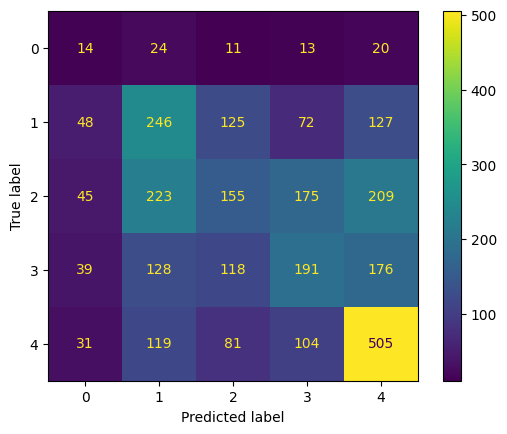


               precision    recall  f1-score   support

           0       0.08      0.17      0.11        82
           1       0.33      0.40      0.36       618
           2       0.32      0.19      0.24       807
           3       0.34      0.29      0.32       652
           4       0.49      0.60      0.54       840

    accuracy                           0.37      2999
   macro avg       0.31      0.33      0.31      2999
weighted avg       0.37      0.37      0.36      2999



In [66]:
model = RandomForestClassifier(random_state=seed)

param_grid = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}

rft_multi = model_evaluation(model, param_grid, X_train, X_test, y_train, y_test, f1_scorer)

- Classifying five classes is significantly more challenging than binary classification.

- Due to the low representation of Class 0, this class consistently shows the weakest performance across models.

- The class with the second-lowest F1-Score is Class 3 for the Decision Tree, Naive Bayes, KNN, and Logistic Regression models, while it shifts to Class 2 for both the SVM and Random Forest models.

- Class 4 consistently shows the strongest performance across models.

- With the exception of the Naive Bayes model, the F1-Score for Class 4 is consistently lower than the F1-Score for Class 0 in the binary classification scenario (Class 4 in this multiclass classification task corresponds to Class 0 in the binary classification scenario).

- Logistic Regression, SVM, and Naive Bayes have the smallest gap between training and testing scores, indicating better generalization.

- Overall, the Random Forest model achieves the best results, despite the notable gap between train and test scores, which suggests some degree of overfitting.

#### Predicting AdoptionSpeed (3 classes - multiclass classification)

In [67]:
def convert_to_three_classes(adoption_speed):
    if adoption_speed in [0, 1]:
        return 0
    elif adoption_speed in [2, 3]:
        return 1
    elif adoption_speed == 4:
        return 2

In [68]:
Y = raw_df['AdoptionSpeed'].apply(convert_to_three_classes)
Y.describe()

count    14993.000000
mean         1.046488
std          0.715015
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          2.000000
Name: AdoptionSpeed, dtype: float64

In [69]:
#the split is stratified (maintaining class proportions in train and test)
X_train, X_test, y_train, y_test = train_test_split(X_enc_sca, Y, test_size=0.2, random_state=seed, stratify=Y)
print(pd.Series(y_train).value_counts(normalize=True))

AdoptionSpeed
1    0.48666
2    0.27989
0    0.23345
Name: proportion, dtype: float64


#### Logistic Regression

Train F1-Score: 0.507 +/- 0.003
Test F1-Score: 0.501 +/- 0.006

Train Accuracy: 0.513 +/- 0.003
Test Accuracy: 0.507 +/- 0.006

 {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'} 



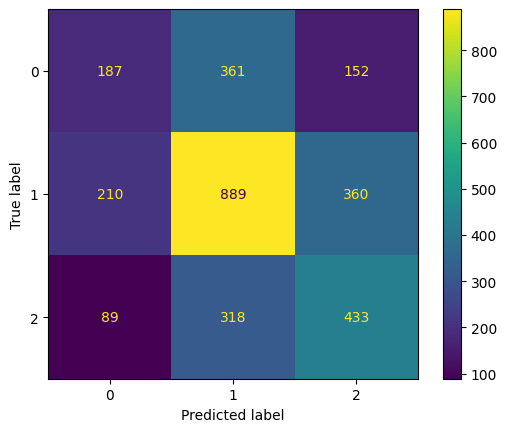


               precision    recall  f1-score   support

           0       0.38      0.27      0.32       700
           1       0.57      0.61      0.59      1459
           2       0.46      0.52      0.49       840

    accuracy                           0.50      2999
   macro avg       0.47      0.46      0.46      2999
weighted avg       0.49      0.50      0.50      2999



In [70]:
model = LogisticRegression(random_state=seed)

param_grid = [
    {'solver': ['lbfgs'], 'penalty': ['l2'], 'C': [0.01, 0.1, 1, 10], 'max_iter': [500, 1000], 'class_weight': [None, 'balanced']},
    {'solver': ['liblinear'], 'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10], 'max_iter': [500,1000], 'class_weight': [None, 'balanced']},
    {'solver': ['saga'], 'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10], 'max_iter': [500,1000], 'class_weight': [None, 'balanced']}
]

lgr_multi3 = model_evaluation(model, param_grid, X_train, X_test, y_train, y_test, f1_scorer)

#### Random Forest

Train F1-Score: 0.792 +/- 0.033
Test F1-Score: 0.495 +/- 0.013

Train Accuracy: 0.791 +/- 0.034
Test Accuracy: 0.495 +/- 0.015

 {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2} 



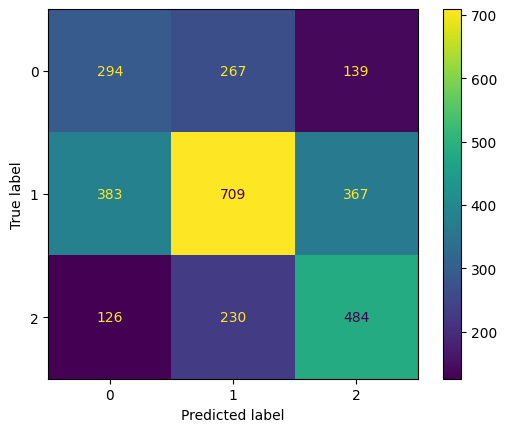


               precision    recall  f1-score   support

           0       0.37      0.42      0.39       700
           1       0.59      0.49      0.53      1459
           2       0.49      0.58      0.53       840

    accuracy                           0.50      2999
   macro avg       0.48      0.49      0.48      2999
weighted avg       0.51      0.50      0.50      2999



In [71]:
model = RandomForestClassifier(random_state=seed)

param_grid = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}

rft_multi3 = model_evaluation(model, param_grid, X_train, X_test, y_train, y_test, f1_scorer)

- Both Random Forest and Logistic Regression perform better when predicting 3 classes rather than 5 classes. 

- For 3-class classification, Logistic Regression demonstrates more consistent performance with less overfitting compared to Random Forest. It achieves a slightly higher F1-score (0.501 vs. 0.495) and exhibits a smaller standard deviation, indicating greater stability across folds.
  
- In the 3-class scenario, class 0 is the hardest one to predict.

- The overall accuracy is similar in both models.

#### Train specialized models for cats and dogs (binary classification)

In [72]:
Y = raw_df['AdoptionSpeed'].map(lambda x: int(x < 4))

In [73]:
X_dogs = X_enc_sca[X_enc_sca['Type_2'] == 0].copy()
Y_dogs = Y.loc[X_enc_sca[X_enc_sca['Type_2'] == 0].index].copy()
X_train_dogs, X_test_dogs, y_train_dogs, y_test_dogs = train_test_split(X_dogs, Y_dogs, test_size=0.2, random_state=seed, stratify=Y_dogs)
print(pd.Series(y_train_dogs).value_counts(normalize=True))

X_cats = X_enc_sca[X_enc_sca['Type_2'] == 1].copy()
Y_cats = Y.loc[X_enc_sca[X_enc_sca['Type_2'] == 1].index].copy()
X_train_cats, X_test_cats, y_train_cats, y_test_cats = train_test_split(X_cats, Y_cats, test_size=0.2, random_state=seed, stratify=Y_cats)
print(pd.Series(y_train_cats).value_counts(normalize=True))

AdoptionSpeed
1    0.703151
0    0.296849
Name: proportion, dtype: float64
AdoptionSpeed
1    0.74016
0    0.25984
Name: proportion, dtype: float64


#### Logistic Regression

In [74]:
model = LogisticRegression(random_state=seed)

param_grid = [
    {'solver': ['lbfgs'], 'penalty': ['l2'], 'C': [0.01, 0.1, 1, 10], 'max_iter': [500, 1000], 'class_weight': [None, 'balanced']},
    {'solver': ['liblinear'], 'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10], 'max_iter': [500,1000], 'class_weight': [None, 'balanced']},
    {'solver': ['saga'], 'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10], 'max_iter': [500,1000], 'class_weight': [None, 'balanced']}
]

Train F1-Score: 0.562 +/- 0.004
Test F1-Score: 0.558 +/- 0.017

Train Accuracy: 0.688 +/- 0.003
Test Accuracy: 0.684 +/- 0.015

 {'C': 1, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l1', 'solver': 'saga'} 



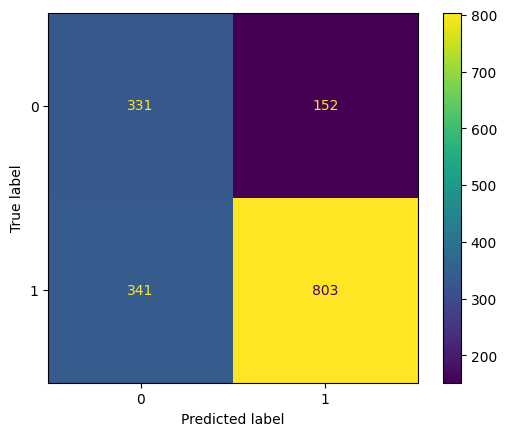


               precision    recall  f1-score   support

           0       0.49      0.69      0.57       483
           1       0.84      0.70      0.77      1144

    accuracy                           0.70      1627
   macro avg       0.67      0.69      0.67      1627
weighted avg       0.74      0.70      0.71      1627



In [75]:
lgr_dogs = model_evaluation(model, param_grid, X_train_dogs, X_test_dogs, y_train_dogs, y_test_dogs, f1_class0_scorer)

Train F1-Score: 0.510 +/- 0.004
Test F1-Score: 0.500 +/- 0.017

Train Accuracy: 0.664 +/- 0.004
Test Accuracy: 0.659 +/- 0.008

 {'C': 1, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'} 



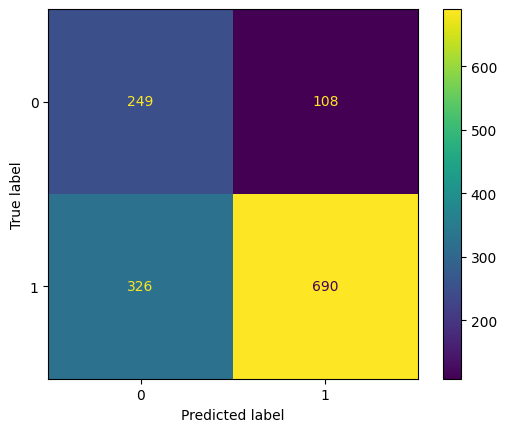


               precision    recall  f1-score   support

           0       0.43      0.70      0.53       357
           1       0.86      0.68      0.76      1016

    accuracy                           0.68      1373
   macro avg       0.65      0.69      0.65      1373
weighted avg       0.75      0.68      0.70      1373



In [76]:
lgr_cats = model_evaluation(model, param_grid, X_train_cats, X_test_cats, y_train_cats, y_test_cats, f1_class0_scorer)

#### Random Forest

In [77]:
model = RandomForestClassifier(random_state=seed)

param_grid = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}

Train F1-Score: 0.675 +/- 0.020
Test F1-Score: 0.562 +/- 0.022

Train Accuracy: 0.781 +/- 0.013
Test Accuracy: 0.706 +/- 0.018

 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10} 



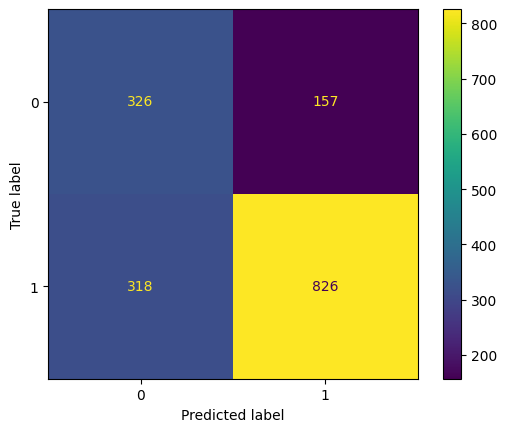


               precision    recall  f1-score   support

           0       0.51      0.67      0.58       483
           1       0.84      0.72      0.78      1144

    accuracy                           0.71      1627
   macro avg       0.67      0.70      0.68      1627
weighted avg       0.74      0.71      0.72      1627



In [78]:
rft_dogs = model_evaluation(model, param_grid, X_train_dogs, X_test_dogs, y_train_dogs, y_test_dogs, f1_class0_scorer)

Train F1-Score: 0.609 +/- 0.048
Test F1-Score: 0.509 +/- 0.013

Train Accuracy: 0.753 +/- 0.051
Test Accuracy: 0.693 +/- 0.031

 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10} 



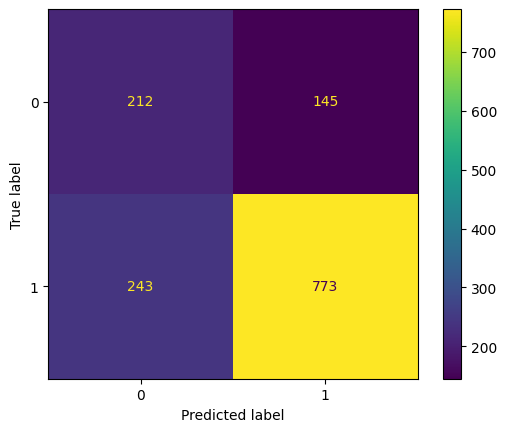


               precision    recall  f1-score   support

           0       0.47      0.59      0.52       357
           1       0.84      0.76      0.80      1016

    accuracy                           0.72      1373
   macro avg       0.65      0.68      0.66      1373
weighted avg       0.74      0.72      0.73      1373



In [79]:
rft_cats = model_evaluation(model, param_grid, X_train_cats, X_test_cats, y_train_cats, y_test_cats, f1_class0_scorer)

- When training specialized models for cats and dogs, both Logistic Regression and Random Forest show improved F1-scores and accuracy in models trained on dogs, while models trained on cats experience a decline in these metrics.

- The performance of both models is similar, with Random Forest slightly outperforming Logistic Regression, despite havinga bigger gap between train and test scores.

## Classification - Final Discussion and Conclusions 

Given this problem, we where able to find two model types that would fit our data the best. We where unable distinguish a single model as "the best one" because both present their strong-suits and trade-offs.
1. Random Forest Classifier
- By being an ensemble model the Random Forest Classifier takes a considerable ammount of time to execute and is one of the more complex models. On the other hand, it was the one with the best results.
2. Logistic Regression
- Following the principle that simpler models are always better. The logistic regression models were performing fairly well to the task of predicting weather a pet was going to be adopted or not. Being just sligthly behind the scores obtained with Random Forest, but requiering much less computation to train. 

The decision of which would be the best model would vary if we are willing to have heavier models in order to get the best results possible or if we are willing to trade a small ammount of model quality in order for it to be much cheaper.

When it comes to the type of classifications performed. We split them into tree:
1. All Pet Types, Binary Classification
2. All Pet Types, Multiclass Classification
3. Cat Pets / Dog Pets, Binary Classification

When it comes to Binary VS Multiclass classification, we can clearly observe that, the overall results have a dip in the performance for multiclass. This is only natural as the task of classifying between multiple classes will always be more complex then classifying as "Yes" or "No". The one thing that was surprising was that for our task the performance wasn't as bad as we thought, as the f1 for the class corresponding to pets that weren't adopted in the multiclass models kept only slightly lower values then the ones from binary classification, and the most significant hit, the one in accuracy it mostly due to classification of pets adoption speed rather then if they where adopted or not at all.

Regarding the differences in Cats and Dogs, we observed that dogs are slightly easier to predict. This is possibly due to the fact that some metrics such as the isPureBreed might have a higher importance for dogs then for cats, making it easier for the model to find patterns between that distinguish pets that are/are not adopted.

## Task 2 (Unsupervised Learning) - Charactering Pets and their Adoption Speed

In [80]:
def drawSillouette(X, labels, header="" ):
    y_lower =10
    clusters=list(set(labels))
    n_clusters=len(clusters)

    fig = plt.figure(figsize=(10,8))
    ax1 = plt.gca()
    ax1.set_xlim([-0.5, 1])
    ax1.set_ylim([0, len(X) + (n_clusters) * 3+ y_lower])
    sil_avg = metrics.silhouette_score(X, labels)
    for i,c in enumerate(clusters):
        silhouette_values = metrics.silhouette_samples(X, labels)
        cs_values = silhouette_values[labels == c]
        cs_values.sort()
        size_ci = cs_values.shape[0]
        y_upper = y_lower + size_ci
        color = cm.nipy_spectral(i / n_clusters) #np.array(["r", "g", "b", "k", "y"])[i] #
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, cs_values, facecolor=color, edgecolor="k", alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_ci, str(c))
        y_lower = y_upper + 3  # 10 for the 0 samples
    ax1.set_title("Silhouette plot "+ header)
    ax1.set_xlabel("Silhouette coefficient")
    ax1.set_ylabel("Clusters")
    ax1.axvline(x=sil_avg, c="r", linestyle="--")

    ax1.set_yticks([]) 
    plt.show()

## Learning and Evaluating Clusters

In [81]:
Y = raw_df['AdoptionSpeed'].copy()

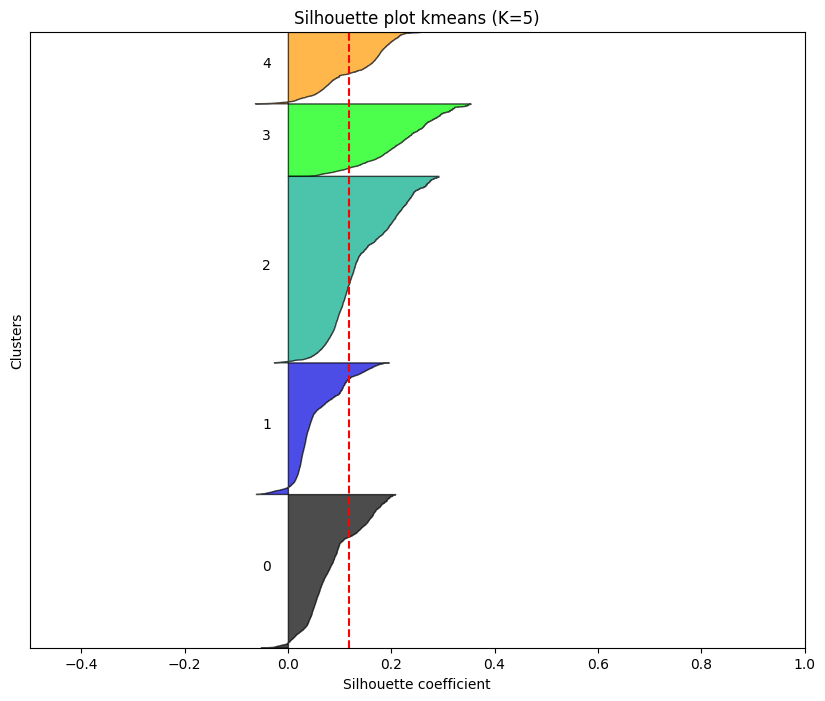

Kmeans Davies-Bouldin score 2.498896995918418
Kmeans Calinski Harabasz score 1525.531031433018

         Cluster 0  Cluster 1  Cluster 2  Cluster 3  Cluster 4
True 0         94         87        137         36         56
True 1        527        723       1137        377        326
True 2        861        978       1329        467        402
True 3        928        690        901        389        351
True 4       1326        729       1042        493        607

Kmeans Homogeneity score 0.009067250796815647
Kmeans Completeness score 0.00862954611804293
Kmeans V-measure score 0.008842985461316453


In [82]:
kmeans5 = KMeans(n_clusters=5, random_state=seed, n_init='auto')
kmeans5_labels = kmeans5.fit_predict(X_enc_sca)

drawSillouette(X_enc_sca, kmeans5_labels, header="kmeans (K=5)")

print("Kmeans Davies-Bouldin score", metrics.davies_bouldin_score(X_enc_sca, kmeans5_labels))
print("Kmeans Calinski Harabasz score", metrics.calinski_harabasz_score(X_enc_sca, kmeans5_labels))

cont_matrix = contingency_matrix(labels_true=Y, labels_pred=kmeans5_labels)

cont_matrix_df = pd.DataFrame(cont_matrix, 
                              index=[f"True {i}" for i in range(5)], 
                              columns=[f"Cluster {i}" for i in range(5)])

print('\n',cont_matrix_df)

print("\nKmeans Homogeneity score", metrics.homogeneity_score(Y, kmeans5_labels))
print("Kmeans Completeness score", metrics.completeness_score(Y, kmeans5_labels))
print("Kmeans V-measure score", metrics.v_measure_score(Y, kmeans5_labels))

Clustering Intrinsic/Internal metrics:
- A lower Davies-Bouldin index relates to a model with better separation between the clusters. This index signifies the average ‘similarity’ between clusters, where the similarity is a measure that compares the distance between clusters with the size of the clusters themselves. A value of 2.51 suggests that the clusters are not well-separated and that there is significant overlap or poor cluster compactness.
- The Calinski-Harabasz index - also known as the Variance Ratio Criterion - can be used to evaluate the model, where a higher Calinski-Harabasz score relates to a model with better defined clusters. While this score is relatively high, its value alone does not provide sufficient insight; its interpretation depends on comparison with other clustering methods or configurations.

Clustering Extrinsic/External metrics:
- The confusion matrix shows that the clusters do not strongly align with the true labels. For example:
    - Each true class is distributed across all clusters with no dominant cluster representing a single class.
    - True Class 2 is spread across all clusters, especially in Cluster 3 (1257) and Cluster 4 (1169), indicating poor separability.
    - True Class 0, being the smallest class, also does not align well, with instances scattered across all clusters.
- The low Homogeneity (0.009), Completeness (0.009), and V-Measure (0.009) scores indicate poor alignment between clusters and true labels, with instances of each class scattered across multiple clusters and no cluster dominated by a single class.

The clustering results suggest that KMeans struggles to identify meaningful groups in the data. The true classes appear to have overlapping or non-linear relationships that KMeans fails to capture effectively.

For n_clusters = 2, the average silhouette score is 0.143
For n_clusters = 3, the average silhouette score is 0.095
For n_clusters = 4, the average silhouette score is 0.109
For n_clusters = 5, the average silhouette score is 0.118
For n_clusters = 6, the average silhouette score is 0.110
For n_clusters = 7, the average silhouette score is 0.106
For n_clusters = 8, the average silhouette score is 0.124
For n_clusters = 9, the average silhouette score is 0.124
For n_clusters = 10, the average silhouette score is 0.123


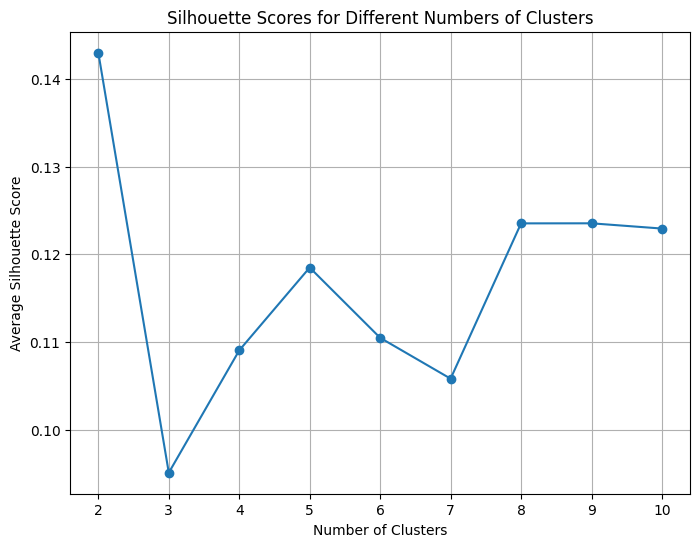

In [83]:
silhouette_scores = []
cluster_range = range(2, 11)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init='auto')
    labels = kmeans.fit_predict(X_enc_sca)
    silhouette_avg = silhouette_score(X_enc_sca, labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, the average silhouette score is {silhouette_avg:.3f}")

# Plot Silhouette Scores
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title("Silhouette Scores for Different Numbers of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Average Silhouette Score")
plt.grid(True)
plt.show()

The Silhouette score reaches its peak with 3 clusters.

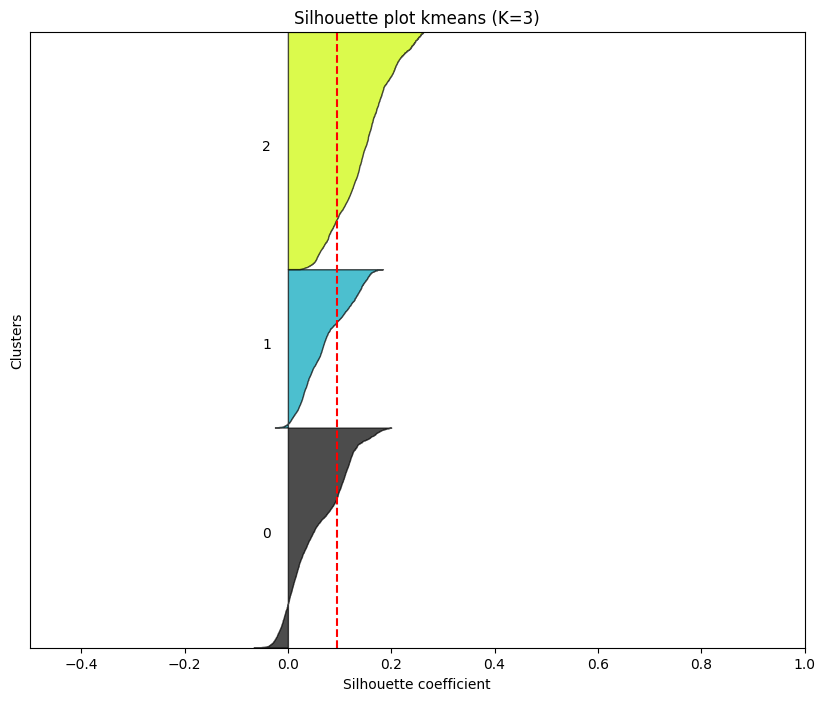

Kmeans Davies-Bouldin score 2.896089848288661
Kmeans Calinski Harabasz score 1700.9579391188781

         Cluster 0  Cluster 1  Cluster 2
True 0        146         96        168
True 1        839        843       1408
True 2       1232       1143       1662
True 3       1247        851       1161
True 4       1890        924       1383

Kmeans Homogeneity score 0.007446859154631246
Kmeans Completeness score 0.010062663699296334
Kmeans V-measure score 0.008559369654356015


In [84]:
kmeans3 = KMeans(n_clusters=3, random_state=seed, n_init='auto')
kmeans3_labels = kmeans3.fit_predict(X_enc_sca)

drawSillouette(X_enc_sca, kmeans3_labels, header="kmeans (K=3)")

print("Kmeans Davies-Bouldin score", metrics.davies_bouldin_score(X_enc_sca, kmeans3_labels))
print("Kmeans Calinski Harabasz score", metrics.calinski_harabasz_score(X_enc_sca, kmeans3_labels))

cont_matrix = contingency_matrix(labels_true=Y, labels_pred=kmeans3_labels)

cont_matrix_df = pd.DataFrame(cont_matrix, 
                              index=[f"True {i}" for i in range(5)], 
                              columns=[f"Cluster {i}" for i in range(3)])

print('\n',cont_matrix_df)

print("\nKmeans Homogeneity score", metrics.homogeneity_score(Y, kmeans3_labels))
print("Kmeans Completeness score", metrics.completeness_score(Y, kmeans3_labels))
print("Kmeans V-measure score", metrics.v_measure_score(Y, kmeans3_labels))

- The Davies-Bouldin and Calinski-Harabasz scores indicate slightly better cluster quality in the 3-cluster scenario. The lower Davies-Bouldin score and higher Calinski-Harabasz score suggest that 3 clusters provide a marginally better-defined structure compared to 5 clusters.

- Instances from all true classes are widely distributed across the three clusters, with no cluster clearly representing a single true class:
    - True Class 0 (smallest class) is scattered across all clusters (e.g., 56 in Cluster 0, 203 in Cluster 1, 151 in Cluster 2).
    - True Classes 1, 2, 3, and 4 are heavily concentrated in Clusters 1 and 2, indicating significant overlap and poor differentiation.
    - Cluster 1 is the largest and absorbs a majority of instances from most true classes, further supporting the lack of well-defined separability.
 
- The Homogeneity (0.008) is slightly lower, Completeness (0.011) slightly higher, and V-Measure (0.009) comparable to the 5-cluster scenario, all indicating poor overall alignment between clusters and true labels.

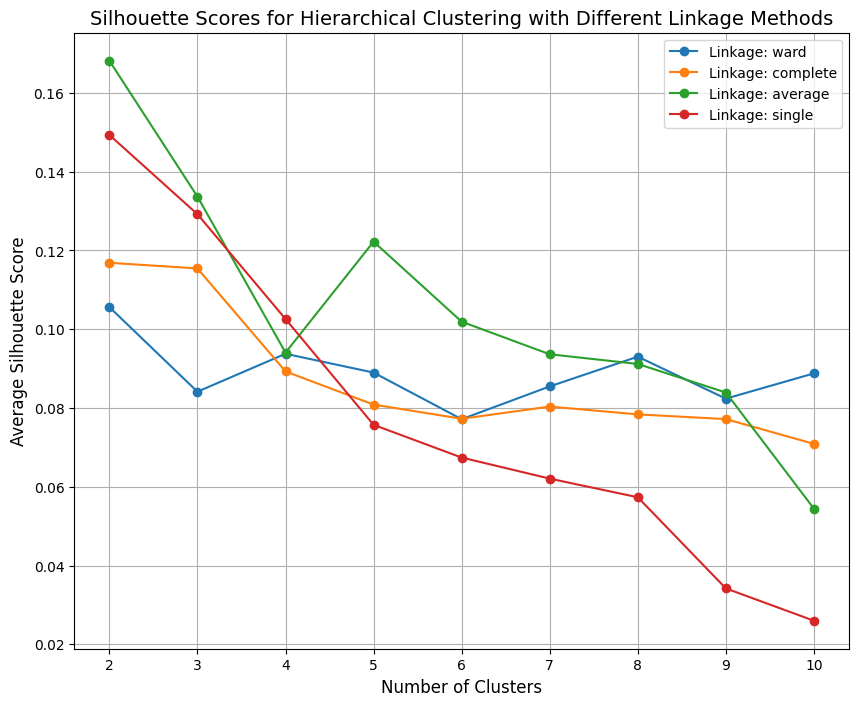

In [85]:
cluster_range = range(2, 11)  # Range of clusters to test
linkage_methods = ['ward', 'complete', 'average', 'single']  # Linkage methods to test

# Dictionary to store silhouette scores for each linkage method
silhouette_scores_hierarchical = {}

for method in linkage_methods:
    silhouette_scores = []
    for n_clusters in cluster_range:
        Z = AgglomerativeClustering(linkage=method, n_clusters=n_clusters).fit(X_enc_sca)
        labels = Z.labels_
        
        silhouette_avg = silhouette_score(X_enc_sca, labels)
        silhouette_scores.append(silhouette_avg)
        # print(f"For linkage={method}, n_clusters={n_clusters}, the average silhouette score is {silhouette_avg:.3f}")
    
    silhouette_scores_hierarchical[method] = silhouette_scores

plt.figure(figsize=(10, 8))
for method, scores in silhouette_scores_hierarchical.items():
    plt.plot(cluster_range, scores, marker='o', label=f"Linkage: {method}")

plt.title("Silhouette Scores for Hierarchical Clustering with Different Linkage Methods", fontsize=14)
plt.xlabel("Number of Clusters", fontsize=12)
plt.ylabel("Average Silhouette Score", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

- Ward linkage maintains a relatively consistent silhouette score as the number of clusters increases, indicating stable cluster quality.
- The other three linkage methods achieve their highest silhouette scores with 2 clusters, but their performance declines as the number of clusters increases, with single linkage experiencing the most significant drop.

## Exploring and performing PCA

In [121]:
from sklearn import decomposition

pca_raw = decomposition.PCA(n_components=5)

X_pca_raw = pca_raw.fit_transform(X_enc_sca[ordinal_cols])

explained_variance_raw = pca_raw.explained_variance_ratio_
explained_variance_raw*5

pca = decomposition.PCA(n_components=3)

X_pca = pca.fit_transform(X_enc_sca[ordinal_cols])

a = pd.DataFrame(pca.components_.T, columns=['PC1','PC2', 'PC3'], index=X_enc_sca[ordinal_cols].columns)
a2= np.square(a)

a2

,PC1,PC2,PC3
MaturitySize,0.001305,0.003515,0.005454
FurLength,0.001261,0.596699,0.337295
ColorsCount,0.730443,0.100970,0.051070
ReducedQuantity,0.204899,0.075259,0.002546
PhotoBinned,0.062091,0.223557,0.603635


In [122]:
print(a2.sort_values(by='PC1', ascending=False))
print(a2.sort_values(by='PC2', ascending=False))
print(a2.sort_values(by='PC3', ascending=False))

                      PC1       PC2       PC3
ColorsCount      0.730443  0.100970  0.051070
ReducedQuantity  0.204899  0.075259  0.002546
PhotoBinned      0.062091  0.223557  0.603635
MaturitySize     0.001305  0.003515  0.005454
FurLength        0.001261  0.596699  0.337295
                      PC1       PC2       PC3
FurLength        0.001261  0.596699  0.337295
PhotoBinned      0.062091  0.223557  0.603635
ColorsCount      0.730443  0.100970  0.051070
ReducedQuantity  0.204899  0.075259  0.002546
MaturitySize     0.001305  0.003515  0.005454
                      PC1       PC2       PC3
PhotoBinned      0.062091  0.223557  0.603635
FurLength        0.001261  0.596699  0.337295
ColorsCount      0.730443  0.100970  0.051070
MaturitySize     0.001305  0.003515  0.005454
ReducedQuantity  0.204899  0.075259  0.002546


With this we can observe the Most relevant features are ColorsCount and ReducedQuantity for PC1, FurLength and PhotoBinned for PC2 and Photo Binned and FurLength for PC3. This suggests PC2 and PC3 have more similarity between eachother rather then with PC1

## Clustering - Final Discussion and Conclusions

By analysing our data with unsupervised methods we got a better understanding of what the data looks like.

In K-Means we used the Silhouette Score to apply the elbow method and obtain the adequate number of clusters to better fit our data.
By doing this, we understood that the K we were looking for was tree clusters. This essentially means there are 3 types of data with more similarity between data of the same type then with others. We used this information to further improve our models performance by performing a test with 3 types of adoption speed instead of the default 5 and the engineered 2.

The other analysis we performed was the Principal Component Analysis in order to reduce the dimentionality of our data and check for the most relevant features. Since we analysed tree clusters in K-Means we went and tried to get the 3 principal components. This let to the top ordinal features being ColoursCounts, FurLength and PhotoBined.

Unfortunately, the PCA wasn't taken into account for supervised learning as it was the last thing the group did and due to time issues weren't able to properly include in the global project.


## 3. Final Comments and Conclusions

Although Machine Learning might be an amazing tool, our group wasn't able to create any close to perfect models. This however doesn't mean that we don't believe we did a good job as the purpose of machine learning isn't to be perfect but rather usefull. Goal which we do believe to have achieved.

The most interseting aspect of the project was finding creative ways to extract as much information as possible from the given data. By performing diverse statistical tests to verify the importance of features as well as to help us avoid bias when engineering new features our of context.

Other then that, we could also verify that no solution fits all as we came up with not one but two best solutions for our supervised problems. We belive this to be a good thing as on a work context we believe the client would appreciate having the ability to decide "between as better as possible, but expensive" and "Sligthly worse but cheap". 

When it came to unsupervised learning we don't believe to have fully extracted the potential of this because we did it last and time due to time issues we were unable to re-create everything based on it. Instead we only experimented with tree classes in multi-class classification to represent the tree clusters found in K-Means.
Were we to start the project knowing this, we could possibly do something such as using the clusters as a feature of its own. Regarding PCA we don't believe our analysis was as good as it could have been, but we could maybe use it to make a more informed feature seletion and engineering.

Overall we belive to have achieved a good project, with meaningfull, usefull models, especialy given that there are a lot of features that aren't being taken into consideration in the data that could have an impact on the models performance.

Some possible metrics that could influence the adoption speed:
1. Marketing expenses for said adoption center
2. Pet admition date (there might be months with more/less adoption probability, this would count for adoption speed.)
3. Number of visitors/pet